In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import torch

from torch import nn, distributions
import torch.optim as optim
from torch.utils.data import DataLoader
from scipy.stats import norm


/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create Dataset

Model:
$$
\theta_1 = 0, \theta_2 = 1, \sigma_x^2 =2 \\
\pi \sim Bernoulli(p=0.5) \\
x_i \sim \pi * N(\theta_1, \sigma_x^2) + (1-\pi) * N(\theta_1 + \theta_2, \sigma_x^2)
$$


NOTE: It looks like to get the multi-model behaviour, I have to use $\sigma_x^2 = 4$ NOT $\sigma_x^2 = 2$ like the paper suggests, most likely a bug in the paper or implementation.

In [2]:
def generate_dataset(theta1, theta2, x_std, N):
    return np.where(np.random.rand(N) >= 0.5, 
                    np.random.normal(theta1, x_std, N), 
                    np.random.normal(theta1 + theta2, x_std, N))


N = 100
theta1, theta2 = 0, 1
x_std = 1.60
np.random.seed(3)
data = generate_dataset(theta1, theta2, x_std, N)
data.shape

(100,)

<AxesSubplot: >

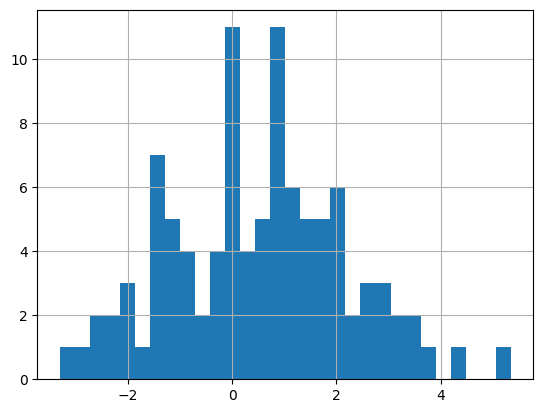

In [3]:
pd.Series(data).hist(bins=30)

# Exact Posterior (Brute Force)

In [4]:
# Make grid of all possible theta1 / theta2
mesh_N = 200
grid = np.meshgrid(np.linspace(-2, 2, mesh_N), np.linspace(-3, 3, mesh_N))
grid = np.stack(grid, axis=2)
grid.shape

(200, 200, 2)

In [5]:
# Compute log pdf of priors
logprob_theta1 = norm.logpdf(grid[:, :, 0], loc=0, scale=np.sqrt(10))
logprob_theta1.shape

logprob_theta2 = norm.logpdf(grid[:, :, 1], loc=0, scale=1)
logprob_theta2.shape

(200, 200)

In [6]:
# Compute log likelihood
# theta1 + theta2 | theta1 ~ N(theta1, sigma2)
log_likelihood = np.zeros(logprob_theta1.shape)
for i, d in enumerate(data):
    prob_x = (0.5 * norm.pdf(d, loc=grid[:, :, 0], scale=np.sqrt(2)) +
              0.5 * norm.pdf(d, loc=grid.sum(axis=2), scale=np.sqrt(2)))
    log_likelihood += np.log(prob_x)

# Normalize log posterior by constant to make it friendlier for np.exp(.) 
unnormalized_log_posterior = log_likelihood + logprob_theta1 + logprob_theta2
log_posterior = unnormalized_log_posterior - unnormalized_log_posterior.max()
posterior = np.exp(log_posterior)
posterior.shape

(200, 200)

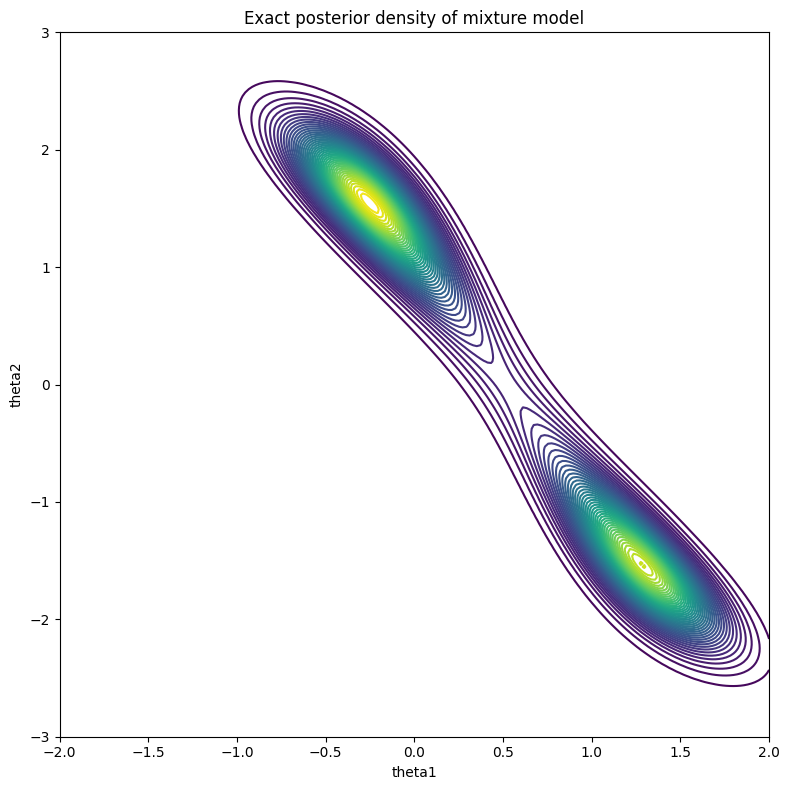

In [7]:
plt.figure(figsize=(8, 8), dpi=100)
xlim = (-2, 2)
ylim = (-3, 3)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.contour(grid[:, :, 0], grid[:, :, 1], posterior, 
            #extent=xlim+ylim, 
            levels=50)
plt.title('Exact posterior density of mixture model')
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.tight_layout()

# MCMC

Model:
$$
\theta_1 \sim N(0, \sigma_1^2=10) \\
\theta_2 \sim N(0, \sigma_2^2=1) \\
\pi \sim Bernoulli(p=0.5) \\
x_i \sim \pi * N(\theta_1, \sigma_x^2=2) + (1-\pi) * N(\theta_1 + \theta_2, \sigma_x^2=2) \\
$$

In [8]:
with pm.Model() as model:
    theta1 = pm.Normal("theta1", mu=0, sigma=np.sqrt(10))
    theta2 = pm.Normal("theta2", mu=0, sigma=1)
    obs = pm.NormalMixture("obs", w=[0.5, 0.5], 
                           mu=[theta1, theta1 + theta2], 
                           sigma=[np.sqrt(2), np.sqrt(2)], 
                           observed=data)

    idata = pm.sample(5000, chains=1, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta1, theta2]


Sampling 1 chain for 2_000 tune and 5_000 draw iterations (2_000 + 5_000 draws total) took 10 seconds.


In [9]:
df_mcmc = pd.DataFrame({'theta1': idata.posterior['theta1'][0],
                        'theta2': idata.posterior['theta2'][0]})

df_mcmc.describe()

,theta1,theta2
count,5000.000000,5000.000000
mean,0.526210,-0.015985
std,0.766085,1.502709
min,-1.098380,-2.810412
25%,-0.200895,-1.469499
50%,0.598723,-0.159277
75%,1.240559,1.478559
max,2.187646,2.767911


<AxesSubplot: >

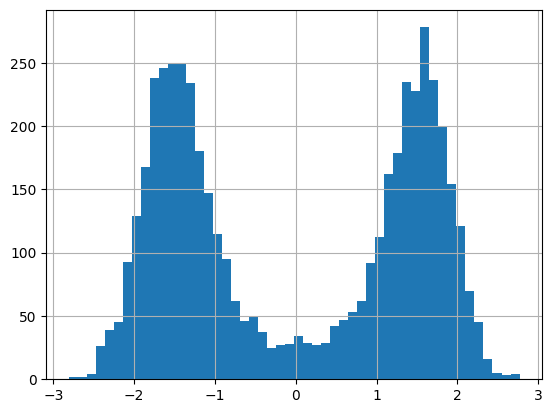

In [10]:
df_mcmc['theta2'].hist(bins=50)

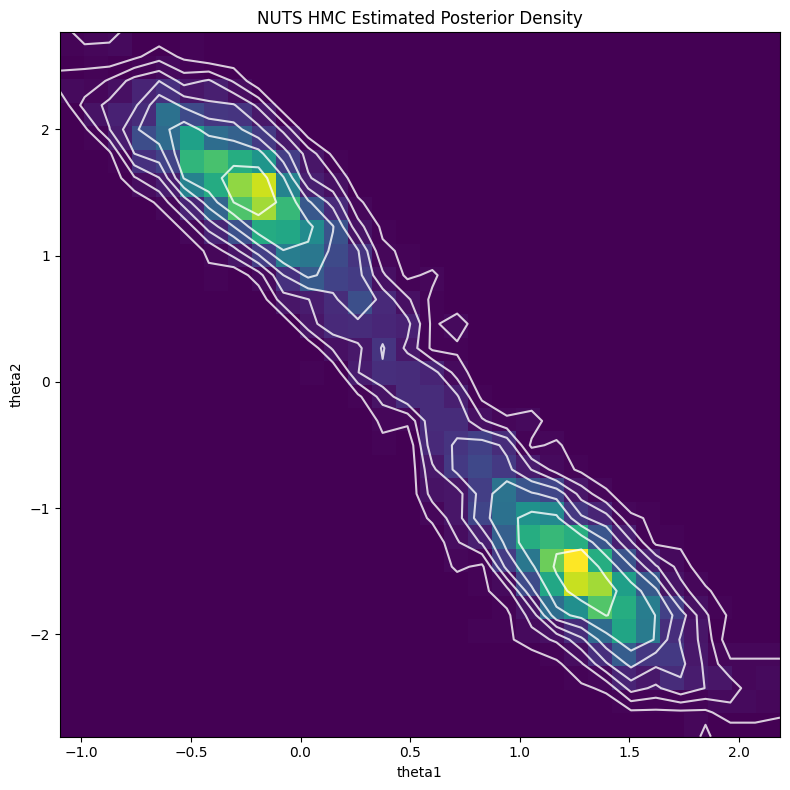

In [11]:
X, Y = df_mcmc.transpose().values
X, Y
plt.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
h, xs, ys, image = plt.hist2d(X, Y, bins=[30, 30])
plt.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
            colors='white', alpha=0.8)
plt.title('NUTS HMC Estimated Posterior Density')
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.tight_layout()

<AxesSubplot: title={'center': 'NUTS HMC Samples (PyMC)'}, xlabel='theta1', ylabel='theta2'>

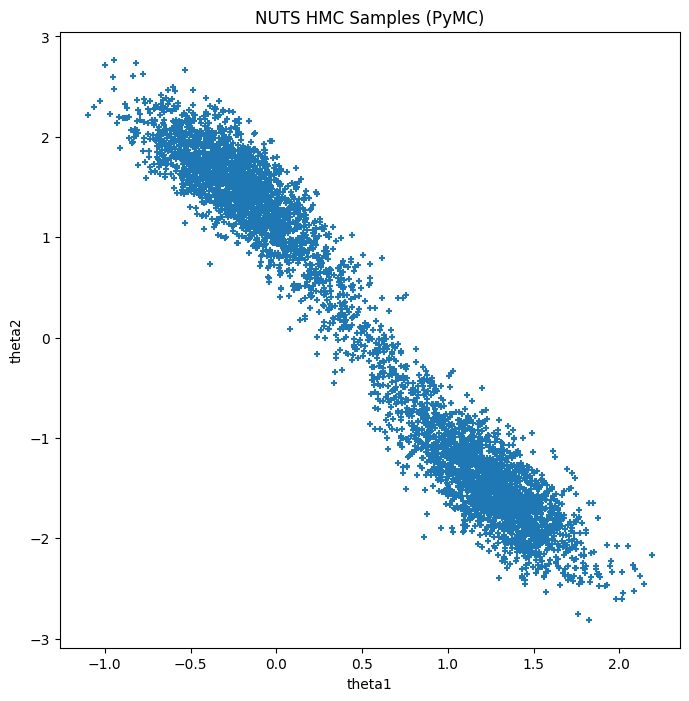

In [12]:
df_mcmc.plot.scatter(x=0, y=1, marker='+', 
                     #xlim=xlim, ylim=ylim,
                     figsize=(8,8),
                title='NUTS HMC Samples (PyMC)')

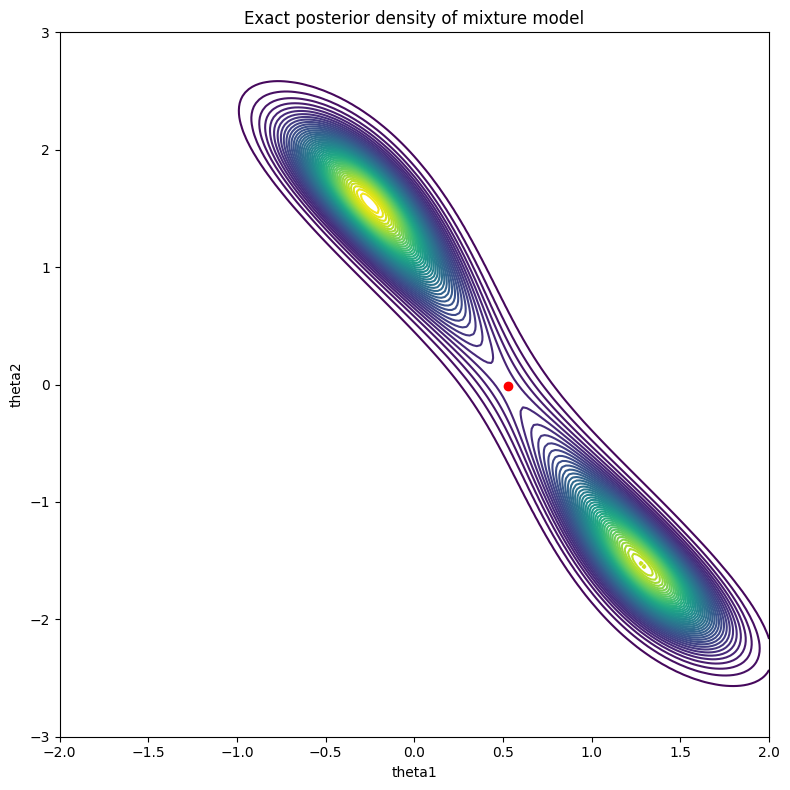

In [13]:
plt.figure(figsize=(8, 8), dpi=100)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.contour(grid[:, :, 0], grid[:, :, 1], posterior, 
            extent=xlim+ylim, 
            levels=50)
plt.title('Exact posterior density of mixture model')
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.plot(df_mcmc['theta1'].mean(), df_mcmc['theta2'].mean(), 'ro') 
plt.tight_layout()

# Stochastic Gradient Langevin Dynamics

Model:
$$
\theta_1 \sim N(0, \sigma_1^2=10) \\
\theta_2 \sim N(0, \sigma_2^2=1) \\
\pi \sim Bernoulli(p=0.5) \\
x_i \sim \pi * N(\theta_1, \sigma_x^2=2) + (1-\pi) * N(\theta_1 + \theta_2, \sigma_x^2=2) \\
\\
\text{Note: } \theta_1+\theta_2|\theta_1 \sim N(\theta_1, \sigma_2^2)
$$

In [14]:
class MixtureModel(nn.Module):
    def __init__(self, theta1_var, theta2_var, x_var):
        super(MixtureModel, self).__init__()
        self.theta1_var = theta1_var
        self.theta2_var = theta2_var
        self.x_std = torch.sqrt(x_var)
        self.theta = nn.Parameter(torch.ones(2))

    def forward(self):
        mean1 = self.theta[0]
        mean2 = self.theta.sum()
        mixture_means = torch.cat([torch.unsqueeze(mean1, 0), torch.unsqueeze(mean2, 0)])
        return mixture_means

    def _gmm(self, mixture_means):
        mix = distributions.Categorical(torch.ones(2,))
        comp = distributions.Normal(loc=mixture_means, scale=torch.tensor([self.x_std, self.x_std]))
        return distributions.MixtureSameFamily(mix, comp)
   
    def loss(self, mixture_means, batch_data, N):
        log_likelihood = - N / len(batch_data) * self._gmm(mixture_means).log_prob(batch_data).sum()
        log_prior = (torch.nn.functional.gaussian_nll_loss(torch.zeros(1),  self.theta[0], self.theta1_var)
                     + torch.nn.functional.gaussian_nll_loss(torch.zeros(1),  self.theta[1], self.theta2_var))
        return log_likelihood + log_prior

In [15]:
class MixtureDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super(MixtureDataset).__init__()
        self.data = torch.tensor(data)
        
    def __len__(self):
        return len(data)

    def __getitem__(self, idx):
        return data[idx]

batch_size = 100
mixture_dataset = MixtureDataset(data)
train_dataloader = DataLoader(mixture_dataset, batch_size=batch_size, shuffle=True)

## Regular Stochastic Gradient Descent

In [16]:
torch_model = MixtureModel(theta1_var=torch.tensor(10.),
                           theta2_var=torch.tensor(1.),
                           x_var=torch.tensor(2.))
optimizer = optim.SGD(torch_model.parameters(), lr=0.01)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)

print(data.mean())
epoch = 0
for epoch in range(300):
    running_loss = 0.
    for i, batch_data in enumerate(train_dataloader, 0):
        torch_model.zero_grad()

        mixture_means = torch_model()
        theta = torch_model.theta
        loss = torch_model.loss(mixture_means, batch_data, len(data))
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    lr_scheduler.step(running_loss)
    if epoch % 10 == 9:
        print(f'[{epoch+1}, {i+1}] loss: {running_loss:.5f}')
        
parameters = next(torch_model.parameters())
parameters

0.5192015550409603
[10, 1] loss: 197.83314
[20, 1] loss: 197.46960
[30, 1] loss: 197.18312
[40, 1] loss: 196.99635
[50, 1] loss: 196.89120
[60, 1] loss: 196.83790
[70, 1] loss: 196.81274
[80, 1] loss: 196.80141
[90, 1] loss: 196.79821
[100, 1] loss: 196.79700
[110, 1] loss: 196.79647
[120, 1] loss: 196.79621
[130, 1] loss: 196.79607
[140, 1] loss: 196.79601
[150, 1] loss: 196.79597
[160, 1] loss: 196.79595
[170, 1] loss: 196.79594
[180, 1] loss: 196.79594
[190, 1] loss: 196.79593
[200, 1] loss: 196.79593
[210, 1] loss: 196.79593
[220, 1] loss: 196.79593
[230, 1] loss: 196.79593
[240, 1] loss: 196.79593
[250, 1] loss: 196.79593
[260, 1] loss: 196.79593
[270, 1] loss: 196.79593
[280, 1] loss: 196.79593
[290, 1] loss: 196.79593
[300, 1] loss: 196.79593


Parameter containing:
tensor([-0.2327,  1.5129], requires_grad=True)

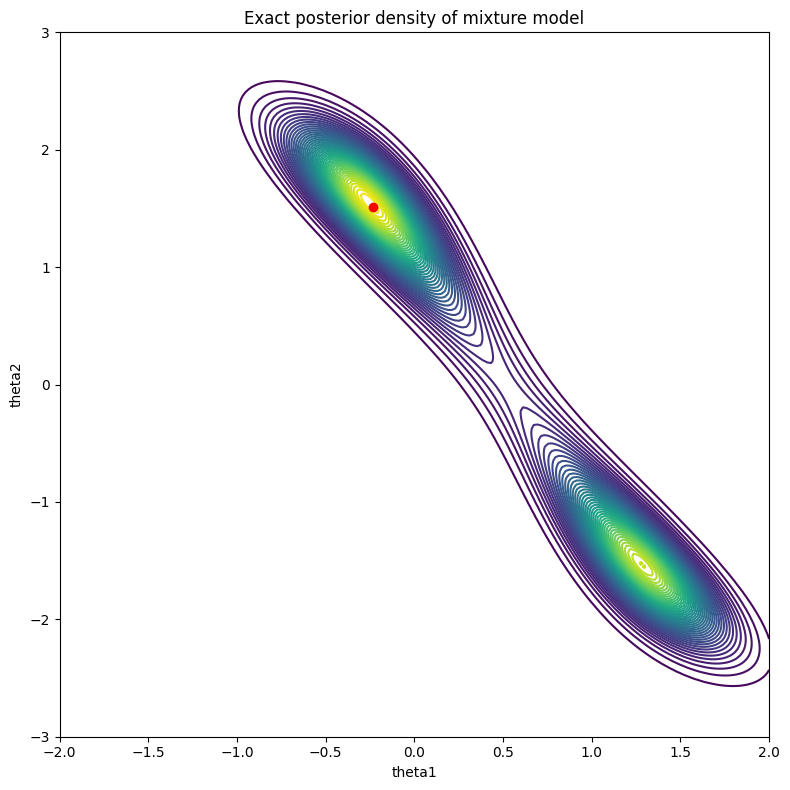

In [17]:
plt.figure(figsize=(8, 8), dpi=100)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.contour(grid[:, :, 0], grid[:, :, 1], posterior, 
            extent=xlim+ylim, 
            levels=50)
plt.title('Exact posterior density of mixture model')
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.plot(parameters[0].item(), parameters[1].item(), 'ro') 
plt.tight_layout()

## Stochastic Gradient Langevin Dynamics

In [4]:
def compute_lr(t, start=0.01, end=0.0001):
    gamma = 0.55
    b = 1e4 * len(data) / batch_size / ((end / start) ** (-1/gamma) - 1) 
    a = start * (b ** gamma)
    return a * ((b + t) ** (-gamma))

print(f't=0:     {compute_lr(0):4f}\nt=10000: {compute_lr(10000 * 1 ):4f}')
print(f't=0:     {compute_lr(0):4f}\nt=100000: {compute_lr(10000 * 10):4f}')
print(f't=0:     {compute_lr(0):4f}\nt=1000000: {compute_lr(10000 * 100):4f}')

t=0:     0.010000
t=10000: 0.000100
t=0:     0.010000
t=100000: 0.000028
t=0:     0.010000
t=1000000: 0.000008


In [19]:
def sample_sgld(batch_size, num_epochs, lr_start=0.01, lr_end=0.0001):
    mixture_dataset = MixtureDataset(data)
    train_dataloader = DataLoader(mixture_dataset, batch_size=batch_size, shuffle=True)
    
    torch_model = MixtureModel(theta1_var=torch.tensor(10.), 
                               theta2_var=torch.tensor(1.), 
                               x_var=torch.tensor(2.))
    
    lr = compute_lr(0)
    samples = []
    
    num_epochs = 10000 * batch_size
    for epoch in range(num_epochs):
        running_loss = 0.
        for i, batch_data in enumerate(train_dataloader, 0):
            torch_model.zero_grad()
          
            mixture_means = torch_model()
            theta = torch_model.theta
            loss = torch_model.loss(mixture_means, batch_data, len(data))
            loss.backward()
           
            with torch.no_grad():
                for p in torch_model.parameters():
                    noise = torch.squeeze(torch.normal(mean=0., std=np.sqrt(lr), size=(2,)))
                    grad = 0.5 * lr * p.grad + noise
                    p.copy_(p - grad)
                    
            running_loss += loss.item()
            lr = compute_lr(len(train_dataloader) * epoch + i, start=lr_start, end=lr_end)
            
            samples.append([theta[0].item() for x in torch_model.parameters()] 
                           + [theta[1].item() for x in torch_model.parameters()]
                           + [lr])
        
        if epoch % 100 == 99:
            print(f'[{epoch+1}] loss: {running_loss:.3f}, lr: {lr:.5f}')
    
    return samples

In [20]:
samples = {}
df_sgld = {}
for batch_size, lr_start, lr_end in [(100, 10.01, 0.001), (10, 0.01, 0.0001), (1, 0.01, 0.0001)]:
    print(f'============== {batch_size} =============')
    samples[batch_size] = sample_sgld(batch_size, lr_start, lr_end)
    df_sgld[batch_size] = pd.DataFrame(samples[batch_size], columns=['theta1', 'theta2', 'eps'])
    
for batch_size in [100, 10, 1]:
    print(f'============== {batch_size} =============')
    display(df_sgld[batch_size].describe())
    theta1_adj_mean = (df_sgld[batch_size]['theta1'] * df_sgld[batch_size]['eps']).sum() / df_sgld[batch_size]['eps'].sum()
    theta2_adj_mean = (df_sgld[batch_size]['theta2'] * df_sgld[batch_size]['eps']).sum() / df_sgld[batch_size]['eps'].sum()
    print(f'Adjusted means:\n * theta1: {theta1_adj_mean}\n * theta2: {theta2_adj_mean}')

============== 100 =============
[100] loss: 198.539, lr: 0.00076
[200] loss: 198.385, lr: 0.00063
[300] loss: 197.272, lr: 0.00055
[400] loss: 198.439, lr: 0.00049
[500] loss: 198.548, lr: 0.00045
[600] loss: 198.231, lr: 0.00042
[700] loss: 198.206, lr: 0.00039
[800] loss: 198.464, lr: 0.00036
[900] loss: 199.930, lr: 0.00035
[1000] loss: 198.947, lr: 0.00033
[1100] loss: 199.970, lr: 0.00031
[1200] loss: 200.756, lr: 0.00030
[1300] loss: 198.534, lr: 0.00029
[1400] loss: 198.724, lr: 0.00028
[1500] loss: 198.710, lr: 0.00027
[1600] loss: 198.878, lr: 0.00026
[1700] loss: 199.954, lr: 0.00025
[1800] loss: 198.916, lr: 0.00025
[1900] loss: 198.943, lr: 0.00024
[2000] loss: 199.558, lr: 0.00023
[2100] loss: 199.368, lr: 0.00023
[2200] loss: 199.505, lr: 0.00022
[2300] loss: 198.837, lr: 0.00022
[2400] loss: 198.882, lr: 0.00021
[2500] loss: 199.235, lr: 0.00021
[2600] loss: 198.533, lr: 0.00020
[2700] loss: 198.866, lr: 0.00020
[2800] loss: 198.272, lr: 0.00020
[2900] loss: 198.472, lr

[23800] loss: 196.866, lr: 0.00006
[23900] loss: 196.859, lr: 0.00006
[24000] loss: 196.858, lr: 0.00006
[24100] loss: 196.840, lr: 0.00006
[24200] loss: 196.877, lr: 0.00006
[24300] loss: 197.218, lr: 0.00006
[24400] loss: 197.448, lr: 0.00006
[24500] loss: 196.907, lr: 0.00006
[24600] loss: 196.837, lr: 0.00006
[24700] loss: 196.992, lr: 0.00006
[24800] loss: 197.363, lr: 0.00006
[24900] loss: 197.882, lr: 0.00006
[25000] loss: 198.645, lr: 0.00006
[25100] loss: 197.177, lr: 0.00006
[25200] loss: 197.120, lr: 0.00006
[25300] loss: 197.057, lr: 0.00006
[25400] loss: 197.374, lr: 0.00006
[25500] loss: 197.282, lr: 0.00006
[25600] loss: 197.317, lr: 0.00006
[25700] loss: 197.006, lr: 0.00006
[25800] loss: 197.235, lr: 0.00006
[25900] loss: 197.035, lr: 0.00006
[26000] loss: 197.031, lr: 0.00006
[26100] loss: 197.004, lr: 0.00006
[26200] loss: 198.150, lr: 0.00006
[26300] loss: 198.152, lr: 0.00006
[26400] loss: 198.321, lr: 0.00006
[26500] loss: 199.203, lr: 0.00006
[26600] loss: 197.62

[47400] loss: 198.187, lr: 0.00004
[47500] loss: 197.776, lr: 0.00004
[47600] loss: 198.387, lr: 0.00004
[47700] loss: 197.833, lr: 0.00004
[47800] loss: 197.676, lr: 0.00004
[47900] loss: 197.609, lr: 0.00004
[48000] loss: 197.374, lr: 0.00004
[48100] loss: 197.350, lr: 0.00004
[48200] loss: 197.243, lr: 0.00004
[48300] loss: 197.230, lr: 0.00004
[48400] loss: 197.520, lr: 0.00004
[48500] loss: 197.502, lr: 0.00004
[48600] loss: 197.706, lr: 0.00004
[48700] loss: 197.528, lr: 0.00004
[48800] loss: 198.550, lr: 0.00004
[48900] loss: 197.462, lr: 0.00004
[49000] loss: 197.235, lr: 0.00004
[49100] loss: 197.207, lr: 0.00004
[49200] loss: 197.398, lr: 0.00004
[49300] loss: 196.995, lr: 0.00004
[49400] loss: 197.007, lr: 0.00004
[49500] loss: 196.935, lr: 0.00004
[49600] loss: 197.017, lr: 0.00004
[49700] loss: 196.973, lr: 0.00004
[49800] loss: 196.950, lr: 0.00004
[49900] loss: 197.336, lr: 0.00004
[50000] loss: 197.455, lr: 0.00004
[50100] loss: 197.599, lr: 0.00004
[50200] loss: 197.25

[71000] loss: 196.914, lr: 0.00003
[71100] loss: 196.868, lr: 0.00003
[71200] loss: 196.910, lr: 0.00003
[71300] loss: 196.889, lr: 0.00003
[71400] loss: 196.884, lr: 0.00003
[71500] loss: 197.014, lr: 0.00003
[71600] loss: 197.092, lr: 0.00003
[71700] loss: 197.100, lr: 0.00003
[71800] loss: 197.123, lr: 0.00003
[71900] loss: 197.048, lr: 0.00003
[72000] loss: 197.173, lr: 0.00003
[72100] loss: 197.130, lr: 0.00003
[72200] loss: 197.059, lr: 0.00003
[72300] loss: 197.232, lr: 0.00003
[72400] loss: 197.084, lr: 0.00003
[72500] loss: 197.259, lr: 0.00003
[72600] loss: 197.196, lr: 0.00003
[72700] loss: 197.213, lr: 0.00003
[72800] loss: 197.579, lr: 0.00003
[72900] loss: 197.557, lr: 0.00003
[73000] loss: 196.941, lr: 0.00003
[73100] loss: 196.979, lr: 0.00003
[73200] loss: 196.908, lr: 0.00003
[73300] loss: 197.090, lr: 0.00003
[73400] loss: 197.178, lr: 0.00003
[73500] loss: 197.148, lr: 0.00003
[73600] loss: 196.883, lr: 0.00003
[73700] loss: 197.017, lr: 0.00003
[73800] loss: 196.97

[94600] loss: 197.111, lr: 0.00003
[94700] loss: 197.130, lr: 0.00003
[94800] loss: 197.307, lr: 0.00003
[94900] loss: 197.150, lr: 0.00003
[95000] loss: 196.982, lr: 0.00003
[95100] loss: 197.025, lr: 0.00003
[95200] loss: 196.964, lr: 0.00003
[95300] loss: 196.810, lr: 0.00003
[95400] loss: 196.973, lr: 0.00003
[95500] loss: 196.985, lr: 0.00003
[95600] loss: 197.133, lr: 0.00003
[95700] loss: 197.644, lr: 0.00003
[95800] loss: 197.949, lr: 0.00003
[95900] loss: 197.911, lr: 0.00003
[96000] loss: 197.900, lr: 0.00003
[96100] loss: 197.876, lr: 0.00003
[96200] loss: 199.195, lr: 0.00003
[96300] loss: 198.439, lr: 0.00003
[96400] loss: 197.842, lr: 0.00003
[96500] loss: 197.559, lr: 0.00003
[96600] loss: 196.842, lr: 0.00003
[96700] loss: 196.824, lr: 0.00003
[96800] loss: 196.794, lr: 0.00003
[96900] loss: 196.831, lr: 0.00003
[97000] loss: 196.834, lr: 0.00003
[97100] loss: 196.800, lr: 0.00003
[97200] loss: 196.822, lr: 0.00003
[97300] loss: 196.813, lr: 0.00003
[97400] loss: 196.89

[117600] loss: 202.156, lr: 0.00003
[117700] loss: 201.478, lr: 0.00003
[117800] loss: 198.743, lr: 0.00003
[117900] loss: 201.715, lr: 0.00003
[118000] loss: 200.888, lr: 0.00003
[118100] loss: 200.217, lr: 0.00003
[118200] loss: 198.904, lr: 0.00003
[118300] loss: 199.211, lr: 0.00003
[118400] loss: 198.352, lr: 0.00003
[118500] loss: 198.022, lr: 0.00003
[118600] loss: 197.923, lr: 0.00003
[118700] loss: 197.455, lr: 0.00003
[118800] loss: 197.797, lr: 0.00003
[118900] loss: 198.214, lr: 0.00003
[119000] loss: 198.458, lr: 0.00003
[119100] loss: 197.762, lr: 0.00003
[119200] loss: 198.931, lr: 0.00003
[119300] loss: 200.387, lr: 0.00003
[119400] loss: 199.950, lr: 0.00003
[119500] loss: 200.642, lr: 0.00003
[119600] loss: 199.968, lr: 0.00003
[119700] loss: 200.201, lr: 0.00003
[119800] loss: 198.336, lr: 0.00003
[119900] loss: 198.004, lr: 0.00003
[120000] loss: 197.506, lr: 0.00003
[120100] loss: 197.011, lr: 0.00003
[120200] loss: 197.135, lr: 0.00003
[120300] loss: 196.886, lr: 

[140400] loss: 197.251, lr: 0.00002
[140500] loss: 197.104, lr: 0.00002
[140600] loss: 197.217, lr: 0.00002
[140700] loss: 197.080, lr: 0.00002
[140800] loss: 197.112, lr: 0.00002
[140900] loss: 197.538, lr: 0.00002
[141000] loss: 197.454, lr: 0.00002
[141100] loss: 197.358, lr: 0.00002
[141200] loss: 197.377, lr: 0.00002
[141300] loss: 197.156, lr: 0.00002
[141400] loss: 197.184, lr: 0.00002
[141500] loss: 197.111, lr: 0.00002
[141600] loss: 197.213, lr: 0.00002
[141700] loss: 197.374, lr: 0.00002
[141800] loss: 197.239, lr: 0.00002
[141900] loss: 197.365, lr: 0.00002
[142000] loss: 197.822, lr: 0.00002
[142100] loss: 197.323, lr: 0.00002
[142200] loss: 197.098, lr: 0.00002
[142300] loss: 197.048, lr: 0.00002
[142400] loss: 197.157, lr: 0.00002
[142500] loss: 197.786, lr: 0.00002
[142600] loss: 197.290, lr: 0.00002
[142700] loss: 197.103, lr: 0.00002
[142800] loss: 197.060, lr: 0.00002
[142900] loss: 197.288, lr: 0.00002
[143000] loss: 197.196, lr: 0.00002
[143100] loss: 197.262, lr: 

[163200] loss: 198.074, lr: 0.00002
[163300] loss: 197.940, lr: 0.00002
[163400] loss: 197.947, lr: 0.00002
[163500] loss: 198.015, lr: 0.00002
[163600] loss: 198.106, lr: 0.00002
[163700] loss: 198.472, lr: 0.00002
[163800] loss: 198.069, lr: 0.00002
[163900] loss: 198.135, lr: 0.00002
[164000] loss: 198.398, lr: 0.00002
[164100] loss: 198.369, lr: 0.00002
[164200] loss: 198.585, lr: 0.00002
[164300] loss: 198.654, lr: 0.00002
[164400] loss: 198.391, lr: 0.00002
[164500] loss: 198.350, lr: 0.00002
[164600] loss: 198.445, lr: 0.00002
[164700] loss: 198.326, lr: 0.00002
[164800] loss: 198.367, lr: 0.00002
[164900] loss: 198.841, lr: 0.00002
[165000] loss: 198.926, lr: 0.00002
[165100] loss: 198.986, lr: 0.00002
[165200] loss: 199.018, lr: 0.00002
[165300] loss: 199.185, lr: 0.00002
[165400] loss: 198.812, lr: 0.00002
[165500] loss: 199.206, lr: 0.00002
[165600] loss: 198.946, lr: 0.00002
[165700] loss: 198.154, lr: 0.00002
[165800] loss: 198.198, lr: 0.00002
[165900] loss: 198.036, lr: 

[186000] loss: 199.563, lr: 0.00002
[186100] loss: 200.218, lr: 0.00002
[186200] loss: 200.897, lr: 0.00002
[186300] loss: 199.489, lr: 0.00002
[186400] loss: 200.179, lr: 0.00002
[186500] loss: 200.007, lr: 0.00002
[186600] loss: 199.925, lr: 0.00002
[186700] loss: 199.443, lr: 0.00002
[186800] loss: 199.167, lr: 0.00002
[186900] loss: 199.781, lr: 0.00002
[187000] loss: 200.119, lr: 0.00002
[187100] loss: 201.761, lr: 0.00002
[187200] loss: 201.000, lr: 0.00002
[187300] loss: 202.074, lr: 0.00002
[187400] loss: 204.692, lr: 0.00002
[187500] loss: 206.857, lr: 0.00002
[187600] loss: 203.857, lr: 0.00002
[187700] loss: 203.409, lr: 0.00002
[187800] loss: 202.762, lr: 0.00002
[187900] loss: 202.162, lr: 0.00002
[188000] loss: 201.663, lr: 0.00002
[188100] loss: 200.943, lr: 0.00002
[188200] loss: 199.818, lr: 0.00002
[188300] loss: 200.085, lr: 0.00002
[188400] loss: 200.204, lr: 0.00002
[188500] loss: 199.655, lr: 0.00002
[188600] loss: 199.582, lr: 0.00002
[188700] loss: 199.250, lr: 

[208800] loss: 198.477, lr: 0.00002
[208900] loss: 198.466, lr: 0.00002
[209000] loss: 198.344, lr: 0.00002
[209100] loss: 198.235, lr: 0.00002
[209200] loss: 198.170, lr: 0.00002
[209300] loss: 198.161, lr: 0.00002
[209400] loss: 198.200, lr: 0.00002
[209500] loss: 198.391, lr: 0.00002
[209600] loss: 198.823, lr: 0.00002
[209700] loss: 198.858, lr: 0.00002
[209800] loss: 198.374, lr: 0.00002
[209900] loss: 198.891, lr: 0.00002
[210000] loss: 198.715, lr: 0.00002
[210100] loss: 198.489, lr: 0.00002
[210200] loss: 198.654, lr: 0.00002
[210300] loss: 198.976, lr: 0.00002
[210400] loss: 199.927, lr: 0.00002
[210500] loss: 200.366, lr: 0.00002
[210600] loss: 200.207, lr: 0.00002
[210700] loss: 201.052, lr: 0.00002
[210800] loss: 201.503, lr: 0.00002
[210900] loss: 200.569, lr: 0.00002
[211000] loss: 199.398, lr: 0.00002
[211100] loss: 199.560, lr: 0.00002
[211200] loss: 199.366, lr: 0.00002
[211300] loss: 198.821, lr: 0.00002
[211400] loss: 198.553, lr: 0.00002
[211500] loss: 199.452, lr: 

[231700] loss: 197.165, lr: 0.00002
[231800] loss: 197.287, lr: 0.00002
[231900] loss: 197.478, lr: 0.00002
[232000] loss: 197.084, lr: 0.00002
[232100] loss: 197.102, lr: 0.00002
[232200] loss: 197.242, lr: 0.00002
[232300] loss: 197.167, lr: 0.00002
[232400] loss: 197.315, lr: 0.00002
[232500] loss: 197.422, lr: 0.00002
[232600] loss: 197.466, lr: 0.00002
[232700] loss: 197.433, lr: 0.00002
[232800] loss: 197.247, lr: 0.00002
[232900] loss: 197.367, lr: 0.00002
[233000] loss: 197.308, lr: 0.00002
[233100] loss: 197.415, lr: 0.00002
[233200] loss: 197.481, lr: 0.00002
[233300] loss: 197.748, lr: 0.00002
[233400] loss: 197.835, lr: 0.00002
[233500] loss: 197.665, lr: 0.00002
[233600] loss: 197.389, lr: 0.00002
[233700] loss: 197.475, lr: 0.00002
[233800] loss: 197.728, lr: 0.00002
[233900] loss: 197.528, lr: 0.00002
[234000] loss: 197.478, lr: 0.00002
[234100] loss: 197.641, lr: 0.00002
[234200] loss: 197.569, lr: 0.00002
[234300] loss: 197.549, lr: 0.00002
[234400] loss: 197.496, lr: 

[254500] loss: 198.301, lr: 0.00002
[254600] loss: 197.858, lr: 0.00002
[254700] loss: 197.811, lr: 0.00002
[254800] loss: 197.759, lr: 0.00002
[254900] loss: 197.846, lr: 0.00002
[255000] loss: 197.794, lr: 0.00002
[255100] loss: 197.641, lr: 0.00002
[255200] loss: 197.440, lr: 0.00002
[255300] loss: 197.498, lr: 0.00002
[255400] loss: 197.605, lr: 0.00002
[255500] loss: 198.238, lr: 0.00002
[255600] loss: 197.989, lr: 0.00002
[255700] loss: 197.605, lr: 0.00002
[255800] loss: 197.824, lr: 0.00002
[255900] loss: 197.797, lr: 0.00002
[256000] loss: 198.321, lr: 0.00002
[256100] loss: 198.230, lr: 0.00002
[256200] loss: 197.825, lr: 0.00002
[256300] loss: 197.583, lr: 0.00002
[256400] loss: 197.201, lr: 0.00002
[256500] loss: 197.231, lr: 0.00002
[256600] loss: 197.016, lr: 0.00002
[256700] loss: 196.894, lr: 0.00002
[256800] loss: 196.877, lr: 0.00002
[256900] loss: 196.993, lr: 0.00002
[257000] loss: 196.889, lr: 0.00002
[257100] loss: 196.917, lr: 0.00002
[257200] loss: 196.949, lr: 

[277300] loss: 196.871, lr: 0.00002
[277400] loss: 196.817, lr: 0.00002
[277500] loss: 196.833, lr: 0.00002
[277600] loss: 196.858, lr: 0.00002
[277700] loss: 196.865, lr: 0.00002
[277800] loss: 196.965, lr: 0.00002
[277900] loss: 197.387, lr: 0.00002
[278000] loss: 197.480, lr: 0.00002
[278100] loss: 197.346, lr: 0.00002
[278200] loss: 197.298, lr: 0.00002
[278300] loss: 197.220, lr: 0.00002
[278400] loss: 197.537, lr: 0.00002
[278500] loss: 197.199, lr: 0.00002
[278600] loss: 197.156, lr: 0.00002
[278700] loss: 197.520, lr: 0.00002
[278800] loss: 197.551, lr: 0.00002
[278900] loss: 197.642, lr: 0.00002
[279000] loss: 198.219, lr: 0.00002
[279100] loss: 198.209, lr: 0.00002
[279200] loss: 198.121, lr: 0.00002
[279300] loss: 197.360, lr: 0.00002
[279400] loss: 197.310, lr: 0.00002
[279500] loss: 197.051, lr: 0.00002
[279600] loss: 197.000, lr: 0.00002
[279700] loss: 197.032, lr: 0.00002
[279800] loss: 197.096, lr: 0.00002
[279900] loss: 197.082, lr: 0.00002
[280000] loss: 197.217, lr: 

[300100] loss: 197.273, lr: 0.00002
[300200] loss: 197.284, lr: 0.00002
[300300] loss: 197.273, lr: 0.00002
[300400] loss: 197.105, lr: 0.00002
[300500] loss: 196.992, lr: 0.00002
[300600] loss: 197.054, lr: 0.00002
[300700] loss: 197.086, lr: 0.00002
[300800] loss: 197.162, lr: 0.00002
[300900] loss: 197.054, lr: 0.00002
[301000] loss: 197.088, lr: 0.00002
[301100] loss: 196.993, lr: 0.00002
[301200] loss: 196.938, lr: 0.00002
[301300] loss: 196.914, lr: 0.00002
[301400] loss: 196.902, lr: 0.00002
[301500] loss: 196.971, lr: 0.00002
[301600] loss: 196.891, lr: 0.00002
[301700] loss: 196.947, lr: 0.00002
[301800] loss: 197.051, lr: 0.00002
[301900] loss: 196.890, lr: 0.00002
[302000] loss: 196.877, lr: 0.00002
[302100] loss: 196.906, lr: 0.00002
[302200] loss: 196.896, lr: 0.00002
[302300] loss: 196.915, lr: 0.00002
[302400] loss: 196.957, lr: 0.00002
[302500] loss: 197.030, lr: 0.00002
[302600] loss: 196.884, lr: 0.00002
[302700] loss: 196.992, lr: 0.00002
[302800] loss: 197.121, lr: 

[322900] loss: 197.953, lr: 0.00001
[323000] loss: 197.902, lr: 0.00001
[323100] loss: 197.960, lr: 0.00001
[323200] loss: 197.995, lr: 0.00001
[323300] loss: 198.030, lr: 0.00001
[323400] loss: 198.221, lr: 0.00001
[323500] loss: 198.543, lr: 0.00001
[323600] loss: 198.629, lr: 0.00001
[323700] loss: 198.719, lr: 0.00001
[323800] loss: 199.123, lr: 0.00001
[323900] loss: 199.416, lr: 0.00001
[324000] loss: 199.420, lr: 0.00001
[324100] loss: 199.532, lr: 0.00001
[324200] loss: 198.864, lr: 0.00001
[324300] loss: 198.892, lr: 0.00001
[324400] loss: 199.825, lr: 0.00001
[324500] loss: 200.431, lr: 0.00001
[324600] loss: 199.998, lr: 0.00001
[324700] loss: 199.897, lr: 0.00001
[324800] loss: 200.696, lr: 0.00001
[324900] loss: 201.139, lr: 0.00001
[325000] loss: 200.826, lr: 0.00001
[325100] loss: 201.084, lr: 0.00001
[325200] loss: 201.197, lr: 0.00001
[325300] loss: 200.640, lr: 0.00001
[325400] loss: 200.478, lr: 0.00001
[325500] loss: 201.040, lr: 0.00001
[325600] loss: 201.594, lr: 

[345700] loss: 198.083, lr: 0.00001
[345800] loss: 198.103, lr: 0.00001
[345900] loss: 197.828, lr: 0.00001
[346000] loss: 198.328, lr: 0.00001
[346100] loss: 198.293, lr: 0.00001
[346200] loss: 198.283, lr: 0.00001
[346300] loss: 198.201, lr: 0.00001
[346400] loss: 198.331, lr: 0.00001
[346500] loss: 198.261, lr: 0.00001
[346600] loss: 198.272, lr: 0.00001
[346700] loss: 198.580, lr: 0.00001
[346800] loss: 198.578, lr: 0.00001
[346900] loss: 198.478, lr: 0.00001
[347000] loss: 198.459, lr: 0.00001
[347100] loss: 198.592, lr: 0.00001
[347200] loss: 198.312, lr: 0.00001
[347300] loss: 198.164, lr: 0.00001
[347400] loss: 198.270, lr: 0.00001
[347500] loss: 198.468, lr: 0.00001
[347600] loss: 198.485, lr: 0.00001
[347700] loss: 198.731, lr: 0.00001
[347800] loss: 198.678, lr: 0.00001
[347900] loss: 198.505, lr: 0.00001
[348000] loss: 198.685, lr: 0.00001
[348100] loss: 198.571, lr: 0.00001
[348200] loss: 198.638, lr: 0.00001
[348300] loss: 198.700, lr: 0.00001
[348400] loss: 198.511, lr: 

[368600] loss: 197.163, lr: 0.00001
[368700] loss: 197.050, lr: 0.00001
[368800] loss: 197.034, lr: 0.00001
[368900] loss: 197.083, lr: 0.00001
[369000] loss: 196.956, lr: 0.00001
[369100] loss: 197.004, lr: 0.00001
[369200] loss: 197.167, lr: 0.00001
[369300] loss: 197.047, lr: 0.00001
[369400] loss: 197.065, lr: 0.00001
[369500] loss: 197.254, lr: 0.00001
[369600] loss: 197.228, lr: 0.00001
[369700] loss: 196.968, lr: 0.00001
[369800] loss: 196.857, lr: 0.00001
[369900] loss: 196.819, lr: 0.00001
[370000] loss: 196.954, lr: 0.00001
[370100] loss: 196.883, lr: 0.00001
[370200] loss: 196.829, lr: 0.00001
[370300] loss: 196.887, lr: 0.00001
[370400] loss: 196.975, lr: 0.00001
[370500] loss: 197.346, lr: 0.00001
[370600] loss: 197.514, lr: 0.00001
[370700] loss: 197.487, lr: 0.00001
[370800] loss: 197.537, lr: 0.00001
[370900] loss: 197.951, lr: 0.00001
[371000] loss: 197.633, lr: 0.00001
[371100] loss: 197.567, lr: 0.00001
[371200] loss: 197.551, lr: 0.00001
[371300] loss: 197.470, lr: 

[391400] loss: 196.852, lr: 0.00001
[391500] loss: 196.872, lr: 0.00001
[391600] loss: 197.034, lr: 0.00001
[391700] loss: 196.952, lr: 0.00001
[391800] loss: 196.925, lr: 0.00001
[391900] loss: 197.015, lr: 0.00001
[392000] loss: 197.099, lr: 0.00001
[392100] loss: 197.448, lr: 0.00001
[392200] loss: 197.184, lr: 0.00001
[392300] loss: 196.976, lr: 0.00001
[392400] loss: 196.978, lr: 0.00001
[392500] loss: 197.056, lr: 0.00001
[392600] loss: 197.045, lr: 0.00001
[392700] loss: 196.908, lr: 0.00001
[392800] loss: 196.927, lr: 0.00001
[392900] loss: 196.914, lr: 0.00001
[393000] loss: 196.993, lr: 0.00001
[393100] loss: 197.080, lr: 0.00001
[393200] loss: 196.906, lr: 0.00001
[393300] loss: 196.944, lr: 0.00001
[393400] loss: 196.931, lr: 0.00001
[393500] loss: 196.995, lr: 0.00001
[393600] loss: 196.987, lr: 0.00001
[393700] loss: 197.125, lr: 0.00001
[393800] loss: 197.077, lr: 0.00001
[393900] loss: 197.265, lr: 0.00001
[394000] loss: 197.188, lr: 0.00001
[394100] loss: 197.294, lr: 

[414200] loss: 197.585, lr: 0.00001
[414300] loss: 197.767, lr: 0.00001
[414400] loss: 197.592, lr: 0.00001
[414500] loss: 197.281, lr: 0.00001
[414600] loss: 197.103, lr: 0.00001
[414700] loss: 197.175, lr: 0.00001
[414800] loss: 197.384, lr: 0.00001
[414900] loss: 197.302, lr: 0.00001
[415000] loss: 197.189, lr: 0.00001
[415100] loss: 197.424, lr: 0.00001
[415200] loss: 197.281, lr: 0.00001
[415300] loss: 197.628, lr: 0.00001
[415400] loss: 197.230, lr: 0.00001
[415500] loss: 197.089, lr: 0.00001
[415600] loss: 197.301, lr: 0.00001
[415700] loss: 197.288, lr: 0.00001
[415800] loss: 197.594, lr: 0.00001
[415900] loss: 197.581, lr: 0.00001
[416000] loss: 197.439, lr: 0.00001
[416100] loss: 197.384, lr: 0.00001
[416200] loss: 197.235, lr: 0.00001
[416300] loss: 197.099, lr: 0.00001
[416400] loss: 196.989, lr: 0.00001
[416500] loss: 197.021, lr: 0.00001
[416600] loss: 197.065, lr: 0.00001
[416700] loss: 197.155, lr: 0.00001
[416800] loss: 196.979, lr: 0.00001
[416900] loss: 196.912, lr: 

[437000] loss: 198.492, lr: 0.00001
[437100] loss: 199.399, lr: 0.00001
[437200] loss: 198.951, lr: 0.00001
[437300] loss: 198.969, lr: 0.00001
[437400] loss: 199.468, lr: 0.00001
[437500] loss: 199.525, lr: 0.00001
[437600] loss: 198.970, lr: 0.00001
[437700] loss: 199.163, lr: 0.00001
[437800] loss: 198.880, lr: 0.00001
[437900] loss: 198.454, lr: 0.00001
[438000] loss: 198.114, lr: 0.00001
[438100] loss: 198.151, lr: 0.00001
[438200] loss: 197.661, lr: 0.00001
[438300] loss: 197.815, lr: 0.00001
[438400] loss: 197.765, lr: 0.00001
[438500] loss: 197.560, lr: 0.00001
[438600] loss: 197.526, lr: 0.00001
[438700] loss: 197.682, lr: 0.00001
[438800] loss: 197.937, lr: 0.00001
[438900] loss: 197.700, lr: 0.00001
[439000] loss: 197.899, lr: 0.00001
[439100] loss: 198.157, lr: 0.00001
[439200] loss: 197.889, lr: 0.00001
[439300] loss: 197.969, lr: 0.00001
[439400] loss: 198.111, lr: 0.00001
[439500] loss: 198.149, lr: 0.00001
[439600] loss: 198.357, lr: 0.00001
[439700] loss: 198.447, lr: 

[459800] loss: 197.130, lr: 0.00001
[459900] loss: 197.032, lr: 0.00001
[460000] loss: 196.980, lr: 0.00001
[460100] loss: 196.959, lr: 0.00001
[460200] loss: 196.965, lr: 0.00001
[460300] loss: 197.257, lr: 0.00001
[460400] loss: 197.154, lr: 0.00001
[460500] loss: 197.098, lr: 0.00001
[460600] loss: 197.003, lr: 0.00001
[460700] loss: 197.053, lr: 0.00001
[460800] loss: 196.873, lr: 0.00001
[460900] loss: 196.982, lr: 0.00001
[461000] loss: 197.261, lr: 0.00001
[461100] loss: 197.135, lr: 0.00001
[461200] loss: 197.169, lr: 0.00001
[461300] loss: 197.557, lr: 0.00001
[461400] loss: 197.549, lr: 0.00001
[461500] loss: 197.636, lr: 0.00001
[461600] loss: 197.985, lr: 0.00001
[461700] loss: 197.878, lr: 0.00001
[461800] loss: 197.572, lr: 0.00001
[461900] loss: 197.931, lr: 0.00001
[462000] loss: 197.722, lr: 0.00001
[462100] loss: 198.337, lr: 0.00001
[462200] loss: 198.110, lr: 0.00001
[462300] loss: 197.737, lr: 0.00001
[462400] loss: 197.399, lr: 0.00001
[462500] loss: 197.447, lr: 

[482600] loss: 197.391, lr: 0.00001
[482700] loss: 197.493, lr: 0.00001
[482800] loss: 197.568, lr: 0.00001
[482900] loss: 197.628, lr: 0.00001
[483000] loss: 197.695, lr: 0.00001
[483100] loss: 197.398, lr: 0.00001
[483200] loss: 197.413, lr: 0.00001
[483300] loss: 197.436, lr: 0.00001
[483400] loss: 197.495, lr: 0.00001
[483500] loss: 197.724, lr: 0.00001
[483600] loss: 198.027, lr: 0.00001
[483700] loss: 197.570, lr: 0.00001
[483800] loss: 197.423, lr: 0.00001
[483900] loss: 197.369, lr: 0.00001
[484000] loss: 197.394, lr: 0.00001
[484100] loss: 197.457, lr: 0.00001
[484200] loss: 197.283, lr: 0.00001
[484300] loss: 197.399, lr: 0.00001
[484400] loss: 197.417, lr: 0.00001
[484500] loss: 197.315, lr: 0.00001
[484600] loss: 197.320, lr: 0.00001
[484700] loss: 197.352, lr: 0.00001
[484800] loss: 197.323, lr: 0.00001
[484900] loss: 197.173, lr: 0.00001
[485000] loss: 197.070, lr: 0.00001
[485100] loss: 197.141, lr: 0.00001
[485200] loss: 197.171, lr: 0.00001
[485300] loss: 196.967, lr: 

[505400] loss: 198.391, lr: 0.00001
[505500] loss: 198.664, lr: 0.00001
[505600] loss: 198.902, lr: 0.00001
[505700] loss: 199.055, lr: 0.00001
[505800] loss: 198.665, lr: 0.00001
[505900] loss: 198.450, lr: 0.00001
[506000] loss: 198.554, lr: 0.00001
[506100] loss: 198.922, lr: 0.00001
[506200] loss: 198.787, lr: 0.00001
[506300] loss: 199.139, lr: 0.00001
[506400] loss: 199.763, lr: 0.00001
[506500] loss: 200.518, lr: 0.00001
[506600] loss: 199.726, lr: 0.00001
[506700] loss: 199.371, lr: 0.00001
[506800] loss: 200.122, lr: 0.00001
[506900] loss: 200.797, lr: 0.00001
[507000] loss: 200.226, lr: 0.00001
[507100] loss: 200.387, lr: 0.00001
[507200] loss: 200.147, lr: 0.00001
[507300] loss: 199.870, lr: 0.00001
[507400] loss: 200.289, lr: 0.00001
[507500] loss: 199.806, lr: 0.00001
[507600] loss: 200.519, lr: 0.00001
[507700] loss: 200.917, lr: 0.00001
[507800] loss: 201.204, lr: 0.00001
[507900] loss: 201.453, lr: 0.00001
[508000] loss: 200.392, lr: 0.00001
[508100] loss: 201.079, lr: 

[528200] loss: 196.944, lr: 0.00001
[528300] loss: 197.077, lr: 0.00001
[528400] loss: 196.969, lr: 0.00001
[528500] loss: 196.978, lr: 0.00001
[528600] loss: 196.999, lr: 0.00001
[528700] loss: 196.922, lr: 0.00001
[528800] loss: 196.990, lr: 0.00001
[528900] loss: 196.992, lr: 0.00001
[529000] loss: 197.052, lr: 0.00001
[529100] loss: 197.097, lr: 0.00001
[529200] loss: 197.153, lr: 0.00001
[529300] loss: 197.375, lr: 0.00001
[529400] loss: 197.286, lr: 0.00001
[529500] loss: 197.246, lr: 0.00001
[529600] loss: 197.523, lr: 0.00001
[529700] loss: 197.566, lr: 0.00001
[529800] loss: 198.207, lr: 0.00001
[529900] loss: 197.646, lr: 0.00001
[530000] loss: 197.411, lr: 0.00001
[530100] loss: 197.686, lr: 0.00001
[530200] loss: 197.346, lr: 0.00001
[530300] loss: 197.322, lr: 0.00001
[530400] loss: 197.323, lr: 0.00001
[530500] loss: 197.361, lr: 0.00001
[530600] loss: 197.678, lr: 0.00001
[530700] loss: 197.729, lr: 0.00001
[530800] loss: 197.483, lr: 0.00001
[530900] loss: 197.320, lr: 

[551000] loss: 197.714, lr: 0.00001
[551100] loss: 197.497, lr: 0.00001
[551200] loss: 197.426, lr: 0.00001
[551300] loss: 197.676, lr: 0.00001
[551400] loss: 197.604, lr: 0.00001
[551500] loss: 198.277, lr: 0.00001
[551600] loss: 198.799, lr: 0.00001
[551700] loss: 198.963, lr: 0.00001
[551800] loss: 199.202, lr: 0.00001
[551900] loss: 199.206, lr: 0.00001
[552000] loss: 199.470, lr: 0.00001
[552100] loss: 199.039, lr: 0.00001
[552200] loss: 199.456, lr: 0.00001
[552300] loss: 199.065, lr: 0.00001
[552400] loss: 198.660, lr: 0.00001
[552500] loss: 198.657, lr: 0.00001
[552600] loss: 199.117, lr: 0.00001
[552700] loss: 199.123, lr: 0.00001
[552800] loss: 199.156, lr: 0.00001
[552900] loss: 199.339, lr: 0.00001
[553000] loss: 199.875, lr: 0.00001
[553100] loss: 200.409, lr: 0.00001
[553200] loss: 200.199, lr: 0.00001
[553300] loss: 200.332, lr: 0.00001
[553400] loss: 199.397, lr: 0.00001
[553500] loss: 199.396, lr: 0.00001
[553600] loss: 199.298, lr: 0.00001
[553700] loss: 198.917, lr: 

[573800] loss: 199.271, lr: 0.00001
[573900] loss: 199.683, lr: 0.00001
[574000] loss: 199.688, lr: 0.00001
[574100] loss: 200.021, lr: 0.00001
[574200] loss: 200.119, lr: 0.00001
[574300] loss: 200.364, lr: 0.00001
[574400] loss: 200.389, lr: 0.00001
[574500] loss: 200.536, lr: 0.00001
[574600] loss: 200.736, lr: 0.00001
[574700] loss: 200.617, lr: 0.00001
[574800] loss: 199.969, lr: 0.00001
[574900] loss: 199.854, lr: 0.00001
[575000] loss: 199.817, lr: 0.00001
[575100] loss: 200.132, lr: 0.00001
[575200] loss: 200.239, lr: 0.00001
[575300] loss: 200.677, lr: 0.00001
[575400] loss: 200.724, lr: 0.00001
[575500] loss: 200.861, lr: 0.00001
[575600] loss: 201.010, lr: 0.00001
[575700] loss: 201.259, lr: 0.00001
[575800] loss: 200.818, lr: 0.00001
[575900] loss: 201.033, lr: 0.00001
[576000] loss: 200.817, lr: 0.00001
[576100] loss: 200.247, lr: 0.00001
[576200] loss: 200.452, lr: 0.00001
[576300] loss: 200.408, lr: 0.00001
[576400] loss: 200.288, lr: 0.00001
[576500] loss: 200.296, lr: 

[596600] loss: 200.591, lr: 0.00001
[596700] loss: 200.480, lr: 0.00001
[596800] loss: 200.560, lr: 0.00001
[596900] loss: 200.793, lr: 0.00001
[597000] loss: 200.777, lr: 0.00001
[597100] loss: 200.520, lr: 0.00001
[597200] loss: 200.677, lr: 0.00001
[597300] loss: 200.993, lr: 0.00001
[597400] loss: 200.730, lr: 0.00001
[597500] loss: 201.036, lr: 0.00001
[597600] loss: 201.252, lr: 0.00001
[597700] loss: 201.484, lr: 0.00001
[597800] loss: 201.167, lr: 0.00001
[597900] loss: 201.271, lr: 0.00001
[598000] loss: 201.263, lr: 0.00001
[598100] loss: 201.053, lr: 0.00001
[598200] loss: 201.146, lr: 0.00001
[598300] loss: 201.134, lr: 0.00001
[598400] loss: 201.722, lr: 0.00001
[598500] loss: 201.184, lr: 0.00001
[598600] loss: 201.218, lr: 0.00001
[598700] loss: 200.841, lr: 0.00001
[598800] loss: 200.433, lr: 0.00001
[598900] loss: 199.940, lr: 0.00001
[599000] loss: 200.002, lr: 0.00001
[599100] loss: 199.931, lr: 0.00001
[599200] loss: 199.794, lr: 0.00001
[599300] loss: 199.565, lr: 

[619400] loss: 197.039, lr: 0.00001
[619500] loss: 197.033, lr: 0.00001
[619600] loss: 197.111, lr: 0.00001
[619700] loss: 197.152, lr: 0.00001
[619800] loss: 197.157, lr: 0.00001
[619900] loss: 197.301, lr: 0.00001
[620000] loss: 197.097, lr: 0.00001
[620100] loss: 197.215, lr: 0.00001
[620200] loss: 197.108, lr: 0.00001
[620300] loss: 196.970, lr: 0.00001
[620400] loss: 197.209, lr: 0.00001
[620500] loss: 197.102, lr: 0.00001
[620600] loss: 196.918, lr: 0.00001
[620700] loss: 196.994, lr: 0.00001
[620800] loss: 197.274, lr: 0.00001
[620900] loss: 197.209, lr: 0.00001
[621000] loss: 196.799, lr: 0.00001
[621100] loss: 196.826, lr: 0.00001
[621200] loss: 196.796, lr: 0.00001
[621300] loss: 196.798, lr: 0.00001
[621400] loss: 196.807, lr: 0.00001
[621500] loss: 196.844, lr: 0.00001
[621600] loss: 197.042, lr: 0.00001
[621700] loss: 196.928, lr: 0.00001
[621800] loss: 196.919, lr: 0.00001
[621900] loss: 196.886, lr: 0.00001
[622000] loss: 196.891, lr: 0.00001
[622100] loss: 196.826, lr: 

[642200] loss: 197.343, lr: 0.00001
[642300] loss: 197.227, lr: 0.00001
[642400] loss: 197.185, lr: 0.00001
[642500] loss: 197.789, lr: 0.00001
[642600] loss: 197.462, lr: 0.00001
[642700] loss: 197.362, lr: 0.00001
[642800] loss: 197.333, lr: 0.00001
[642900] loss: 197.755, lr: 0.00001
[643000] loss: 198.133, lr: 0.00001
[643100] loss: 197.790, lr: 0.00001
[643200] loss: 197.507, lr: 0.00001
[643300] loss: 197.485, lr: 0.00001
[643400] loss: 197.306, lr: 0.00001
[643500] loss: 196.981, lr: 0.00001
[643600] loss: 196.839, lr: 0.00001
[643700] loss: 196.837, lr: 0.00001
[643800] loss: 196.829, lr: 0.00001
[643900] loss: 196.819, lr: 0.00001
[644000] loss: 196.896, lr: 0.00001
[644100] loss: 196.943, lr: 0.00001
[644200] loss: 196.911, lr: 0.00001
[644300] loss: 196.942, lr: 0.00001
[644400] loss: 196.875, lr: 0.00001
[644500] loss: 196.956, lr: 0.00001
[644600] loss: 197.158, lr: 0.00001
[644700] loss: 196.881, lr: 0.00001
[644800] loss: 196.855, lr: 0.00001
[644900] loss: 196.956, lr: 

[665000] loss: 198.789, lr: 0.00001
[665100] loss: 198.819, lr: 0.00001
[665200] loss: 198.689, lr: 0.00001
[665300] loss: 198.736, lr: 0.00001
[665400] loss: 198.645, lr: 0.00001
[665500] loss: 198.474, lr: 0.00001
[665600] loss: 198.240, lr: 0.00001
[665700] loss: 198.358, lr: 0.00001
[665800] loss: 198.294, lr: 0.00001
[665900] loss: 198.388, lr: 0.00001
[666000] loss: 197.919, lr: 0.00001
[666100] loss: 197.833, lr: 0.00001
[666200] loss: 197.760, lr: 0.00001
[666300] loss: 197.929, lr: 0.00001
[666400] loss: 197.861, lr: 0.00001
[666500] loss: 197.836, lr: 0.00001
[666600] loss: 198.151, lr: 0.00001
[666700] loss: 198.127, lr: 0.00001
[666800] loss: 197.992, lr: 0.00001
[666900] loss: 198.100, lr: 0.00001
[667000] loss: 197.996, lr: 0.00001
[667100] loss: 197.899, lr: 0.00001
[667200] loss: 198.027, lr: 0.00001
[667300] loss: 197.703, lr: 0.00001
[667400] loss: 197.777, lr: 0.00001
[667500] loss: 197.778, lr: 0.00001
[667600] loss: 197.804, lr: 0.00001
[667700] loss: 197.947, lr: 

[687800] loss: 197.207, lr: 0.00001
[687900] loss: 197.232, lr: 0.00001
[688000] loss: 197.262, lr: 0.00001
[688100] loss: 197.156, lr: 0.00001
[688200] loss: 197.110, lr: 0.00001
[688300] loss: 197.271, lr: 0.00001
[688400] loss: 197.828, lr: 0.00001
[688500] loss: 197.222, lr: 0.00001
[688600] loss: 197.313, lr: 0.00001
[688700] loss: 197.299, lr: 0.00001
[688800] loss: 197.184, lr: 0.00001
[688900] loss: 197.150, lr: 0.00001
[689000] loss: 197.215, lr: 0.00001
[689100] loss: 197.230, lr: 0.00001
[689200] loss: 197.216, lr: 0.00001
[689300] loss: 197.283, lr: 0.00001
[689400] loss: 197.408, lr: 0.00001
[689500] loss: 197.319, lr: 0.00001
[689600] loss: 197.377, lr: 0.00001
[689700] loss: 197.433, lr: 0.00001
[689800] loss: 197.512, lr: 0.00001
[689900] loss: 197.497, lr: 0.00001
[690000] loss: 197.584, lr: 0.00001
[690100] loss: 197.470, lr: 0.00001
[690200] loss: 197.614, lr: 0.00001
[690300] loss: 197.675, lr: 0.00001
[690400] loss: 197.599, lr: 0.00001
[690500] loss: 197.622, lr: 

[710600] loss: 199.056, lr: 0.00001
[710700] loss: 198.180, lr: 0.00001
[710800] loss: 197.800, lr: 0.00001
[710900] loss: 198.149, lr: 0.00001
[711000] loss: 197.635, lr: 0.00001
[711100] loss: 197.756, lr: 0.00001
[711200] loss: 197.803, lr: 0.00001
[711300] loss: 198.170, lr: 0.00001
[711400] loss: 198.279, lr: 0.00001
[711500] loss: 198.903, lr: 0.00001
[711600] loss: 199.283, lr: 0.00001
[711700] loss: 198.559, lr: 0.00001
[711800] loss: 199.075, lr: 0.00001
[711900] loss: 198.698, lr: 0.00001
[712000] loss: 198.337, lr: 0.00001
[712100] loss: 197.615, lr: 0.00001
[712200] loss: 197.623, lr: 0.00001
[712300] loss: 197.599, lr: 0.00001
[712400] loss: 197.398, lr: 0.00001
[712500] loss: 197.939, lr: 0.00001
[712600] loss: 197.913, lr: 0.00001
[712700] loss: 197.985, lr: 0.00001
[712800] loss: 197.837, lr: 0.00001
[712900] loss: 198.511, lr: 0.00001
[713000] loss: 198.214, lr: 0.00001
[713100] loss: 198.098, lr: 0.00001
[713200] loss: 198.250, lr: 0.00001
[713300] loss: 198.842, lr: 

[733400] loss: 196.851, lr: 0.00001
[733500] loss: 196.805, lr: 0.00001
[733600] loss: 196.802, lr: 0.00001
[733700] loss: 196.827, lr: 0.00001
[733800] loss: 196.905, lr: 0.00001
[733900] loss: 197.138, lr: 0.00001
[734000] loss: 197.045, lr: 0.00001
[734100] loss: 196.956, lr: 0.00001
[734200] loss: 197.047, lr: 0.00001
[734300] loss: 197.382, lr: 0.00001
[734400] loss: 197.581, lr: 0.00001
[734500] loss: 197.712, lr: 0.00001
[734600] loss: 197.715, lr: 0.00001
[734700] loss: 197.578, lr: 0.00001
[734800] loss: 197.611, lr: 0.00001
[734900] loss: 197.408, lr: 0.00001
[735000] loss: 197.695, lr: 0.00001
[735100] loss: 197.199, lr: 0.00001
[735200] loss: 197.014, lr: 0.00001
[735300] loss: 197.182, lr: 0.00001
[735400] loss: 196.934, lr: 0.00001
[735500] loss: 196.847, lr: 0.00001
[735600] loss: 197.070, lr: 0.00001
[735700] loss: 197.345, lr: 0.00001
[735800] loss: 197.845, lr: 0.00001
[735900] loss: 197.753, lr: 0.00001
[736000] loss: 197.577, lr: 0.00001
[736100] loss: 197.340, lr: 

[756200] loss: 196.897, lr: 0.00001
[756300] loss: 196.972, lr: 0.00001
[756400] loss: 196.901, lr: 0.00001
[756500] loss: 196.892, lr: 0.00001
[756600] loss: 196.918, lr: 0.00001
[756700] loss: 196.965, lr: 0.00001
[756800] loss: 196.899, lr: 0.00001
[756900] loss: 196.903, lr: 0.00001
[757000] loss: 197.014, lr: 0.00001
[757100] loss: 196.991, lr: 0.00001
[757200] loss: 197.029, lr: 0.00001
[757300] loss: 197.036, lr: 0.00001
[757400] loss: 197.057, lr: 0.00001
[757500] loss: 197.159, lr: 0.00001
[757600] loss: 197.544, lr: 0.00001
[757700] loss: 197.750, lr: 0.00001
[757800] loss: 197.630, lr: 0.00001
[757900] loss: 197.848, lr: 0.00001
[758000] loss: 197.505, lr: 0.00001
[758100] loss: 197.365, lr: 0.00001
[758200] loss: 197.435, lr: 0.00001
[758300] loss: 197.275, lr: 0.00001
[758400] loss: 197.214, lr: 0.00001
[758500] loss: 197.123, lr: 0.00001
[758600] loss: 197.132, lr: 0.00001
[758700] loss: 197.191, lr: 0.00001
[758800] loss: 197.363, lr: 0.00001
[758900] loss: 197.353, lr: 

[779000] loss: 197.138, lr: 0.00001
[779100] loss: 197.137, lr: 0.00001
[779200] loss: 197.215, lr: 0.00001
[779300] loss: 197.035, lr: 0.00001
[779400] loss: 196.993, lr: 0.00001
[779500] loss: 196.964, lr: 0.00001
[779600] loss: 196.939, lr: 0.00001
[779700] loss: 196.992, lr: 0.00001
[779800] loss: 196.938, lr: 0.00001
[779900] loss: 196.998, lr: 0.00001
[780000] loss: 196.932, lr: 0.00001
[780100] loss: 197.221, lr: 0.00001
[780200] loss: 197.218, lr: 0.00001
[780300] loss: 197.040, lr: 0.00001
[780400] loss: 197.194, lr: 0.00001
[780500] loss: 197.113, lr: 0.00001
[780600] loss: 197.180, lr: 0.00001
[780700] loss: 197.344, lr: 0.00001
[780800] loss: 197.334, lr: 0.00001
[780900] loss: 197.486, lr: 0.00001
[781000] loss: 197.483, lr: 0.00001
[781100] loss: 197.796, lr: 0.00001
[781200] loss: 197.486, lr: 0.00001
[781300] loss: 196.942, lr: 0.00001
[781400] loss: 196.887, lr: 0.00001
[781500] loss: 197.067, lr: 0.00001
[781600] loss: 196.916, lr: 0.00001
[781700] loss: 196.892, lr: 

[801800] loss: 197.587, lr: 0.00001
[801900] loss: 197.654, lr: 0.00001
[802000] loss: 197.760, lr: 0.00001
[802100] loss: 197.748, lr: 0.00001
[802200] loss: 197.479, lr: 0.00001
[802300] loss: 197.360, lr: 0.00001
[802400] loss: 197.557, lr: 0.00001
[802500] loss: 197.369, lr: 0.00001
[802600] loss: 197.292, lr: 0.00001
[802700] loss: 197.374, lr: 0.00001
[802800] loss: 197.243, lr: 0.00001
[802900] loss: 197.412, lr: 0.00001
[803000] loss: 197.498, lr: 0.00001
[803100] loss: 197.345, lr: 0.00001
[803200] loss: 197.211, lr: 0.00001
[803300] loss: 197.279, lr: 0.00001
[803400] loss: 197.182, lr: 0.00001
[803500] loss: 197.190, lr: 0.00001
[803600] loss: 196.988, lr: 0.00001
[803700] loss: 197.068, lr: 0.00001
[803800] loss: 197.229, lr: 0.00001
[803900] loss: 197.091, lr: 0.00001
[804000] loss: 197.278, lr: 0.00001
[804100] loss: 197.326, lr: 0.00001
[804200] loss: 197.437, lr: 0.00001
[804300] loss: 197.238, lr: 0.00001
[804400] loss: 197.282, lr: 0.00001
[804500] loss: 197.064, lr: 

[824600] loss: 196.984, lr: 0.00001
[824700] loss: 196.964, lr: 0.00001
[824800] loss: 196.970, lr: 0.00001
[824900] loss: 196.819, lr: 0.00001
[825000] loss: 196.923, lr: 0.00001
[825100] loss: 196.963, lr: 0.00001
[825200] loss: 197.012, lr: 0.00001
[825300] loss: 196.902, lr: 0.00001
[825400] loss: 196.880, lr: 0.00001
[825500] loss: 196.977, lr: 0.00001
[825600] loss: 196.991, lr: 0.00001
[825700] loss: 196.956, lr: 0.00001
[825800] loss: 196.824, lr: 0.00001
[825900] loss: 196.794, lr: 0.00001
[826000] loss: 196.833, lr: 0.00001
[826100] loss: 196.821, lr: 0.00001
[826200] loss: 196.960, lr: 0.00001
[826300] loss: 197.063, lr: 0.00001
[826400] loss: 197.000, lr: 0.00001
[826500] loss: 196.967, lr: 0.00001
[826600] loss: 197.040, lr: 0.00001
[826700] loss: 197.127, lr: 0.00001
[826800] loss: 197.051, lr: 0.00001
[826900] loss: 197.069, lr: 0.00001
[827000] loss: 196.960, lr: 0.00001
[827100] loss: 197.012, lr: 0.00001
[827200] loss: 197.246, lr: 0.00001
[827300] loss: 197.289, lr: 

[847400] loss: 197.077, lr: 0.00001
[847500] loss: 197.090, lr: 0.00001
[847600] loss: 197.195, lr: 0.00001
[847700] loss: 197.129, lr: 0.00001
[847800] loss: 197.006, lr: 0.00001
[847900] loss: 197.102, lr: 0.00001
[848000] loss: 197.091, lr: 0.00001
[848100] loss: 197.016, lr: 0.00001
[848200] loss: 196.945, lr: 0.00001
[848300] loss: 196.960, lr: 0.00001
[848400] loss: 196.905, lr: 0.00001
[848500] loss: 197.090, lr: 0.00001
[848600] loss: 197.168, lr: 0.00001
[848700] loss: 197.183, lr: 0.00001
[848800] loss: 197.357, lr: 0.00001
[848900] loss: 197.237, lr: 0.00001
[849000] loss: 197.065, lr: 0.00001
[849100] loss: 197.165, lr: 0.00001
[849200] loss: 197.477, lr: 0.00001
[849300] loss: 198.019, lr: 0.00001
[849400] loss: 197.850, lr: 0.00001
[849500] loss: 197.773, lr: 0.00001
[849600] loss: 197.956, lr: 0.00001
[849700] loss: 197.574, lr: 0.00001
[849800] loss: 197.650, lr: 0.00001
[849900] loss: 197.570, lr: 0.00001
[850000] loss: 197.222, lr: 0.00001
[850100] loss: 197.222, lr: 

[870200] loss: 198.062, lr: 0.00001
[870300] loss: 197.626, lr: 0.00001
[870400] loss: 197.722, lr: 0.00001
[870500] loss: 197.758, lr: 0.00001
[870600] loss: 197.720, lr: 0.00001
[870700] loss: 197.622, lr: 0.00001
[870800] loss: 197.626, lr: 0.00001
[870900] loss: 197.518, lr: 0.00001
[871000] loss: 197.567, lr: 0.00001
[871100] loss: 197.654, lr: 0.00001
[871200] loss: 197.542, lr: 0.00001
[871300] loss: 197.600, lr: 0.00001
[871400] loss: 197.632, lr: 0.00001
[871500] loss: 197.698, lr: 0.00001
[871600] loss: 197.878, lr: 0.00001
[871700] loss: 197.884, lr: 0.00001
[871800] loss: 197.456, lr: 0.00001
[871900] loss: 197.549, lr: 0.00001
[872000] loss: 197.495, lr: 0.00001
[872100] loss: 197.471, lr: 0.00001
[872200] loss: 197.509, lr: 0.00001
[872300] loss: 197.525, lr: 0.00001
[872400] loss: 197.423, lr: 0.00001
[872500] loss: 197.257, lr: 0.00001
[872600] loss: 197.475, lr: 0.00001
[872700] loss: 197.629, lr: 0.00001
[872800] loss: 197.695, lr: 0.00001
[872900] loss: 197.557, lr: 

[893000] loss: 198.054, lr: 0.00001
[893100] loss: 198.267, lr: 0.00001
[893200] loss: 198.443, lr: 0.00001
[893300] loss: 197.743, lr: 0.00001
[893400] loss: 197.859, lr: 0.00001
[893500] loss: 197.679, lr: 0.00001
[893600] loss: 197.329, lr: 0.00001
[893700] loss: 197.399, lr: 0.00001
[893800] loss: 197.309, lr: 0.00001
[893900] loss: 197.241, lr: 0.00001
[894000] loss: 197.284, lr: 0.00001
[894100] loss: 197.194, lr: 0.00001
[894200] loss: 197.400, lr: 0.00001
[894300] loss: 197.294, lr: 0.00001
[894400] loss: 197.089, lr: 0.00001
[894500] loss: 196.939, lr: 0.00001
[894600] loss: 196.950, lr: 0.00001
[894700] loss: 196.884, lr: 0.00001
[894800] loss: 196.883, lr: 0.00001
[894900] loss: 196.861, lr: 0.00001
[895000] loss: 196.854, lr: 0.00001
[895100] loss: 196.905, lr: 0.00001
[895200] loss: 196.876, lr: 0.00001
[895300] loss: 196.931, lr: 0.00001
[895400] loss: 196.863, lr: 0.00001
[895500] loss: 196.860, lr: 0.00001
[895600] loss: 196.960, lr: 0.00001
[895700] loss: 196.963, lr: 

[915800] loss: 199.152, lr: 0.00001
[915900] loss: 198.886, lr: 0.00001
[916000] loss: 198.102, lr: 0.00001
[916100] loss: 198.147, lr: 0.00001
[916200] loss: 197.887, lr: 0.00001
[916300] loss: 197.806, lr: 0.00001
[916400] loss: 197.619, lr: 0.00001
[916500] loss: 197.668, lr: 0.00001
[916600] loss: 197.480, lr: 0.00001
[916700] loss: 197.585, lr: 0.00001
[916800] loss: 197.789, lr: 0.00001
[916900] loss: 197.633, lr: 0.00001
[917000] loss: 197.774, lr: 0.00001
[917100] loss: 198.107, lr: 0.00001
[917200] loss: 198.148, lr: 0.00001
[917300] loss: 198.543, lr: 0.00001
[917400] loss: 198.056, lr: 0.00001
[917500] loss: 198.256, lr: 0.00001
[917600] loss: 199.444, lr: 0.00001
[917700] loss: 199.422, lr: 0.00001
[917800] loss: 199.762, lr: 0.00001
[917900] loss: 199.065, lr: 0.00001
[918000] loss: 199.479, lr: 0.00001
[918100] loss: 199.805, lr: 0.00001
[918200] loss: 199.585, lr: 0.00001
[918300] loss: 200.078, lr: 0.00001
[918400] loss: 199.116, lr: 0.00001
[918500] loss: 198.816, lr: 

[938600] loss: 198.375, lr: 0.00001
[938700] loss: 198.067, lr: 0.00001
[938800] loss: 197.711, lr: 0.00001
[938900] loss: 197.436, lr: 0.00001
[939000] loss: 197.581, lr: 0.00001
[939100] loss: 197.551, lr: 0.00001
[939200] loss: 197.739, lr: 0.00001
[939300] loss: 198.405, lr: 0.00001
[939400] loss: 197.933, lr: 0.00001
[939500] loss: 198.259, lr: 0.00001
[939600] loss: 198.397, lr: 0.00001
[939700] loss: 198.486, lr: 0.00001
[939800] loss: 198.583, lr: 0.00001
[939900] loss: 198.277, lr: 0.00001
[940000] loss: 197.895, lr: 0.00001
[940100] loss: 197.816, lr: 0.00001
[940200] loss: 197.543, lr: 0.00001
[940300] loss: 197.471, lr: 0.00001
[940400] loss: 197.760, lr: 0.00001
[940500] loss: 198.012, lr: 0.00001
[940600] loss: 197.983, lr: 0.00001
[940700] loss: 198.291, lr: 0.00001
[940800] loss: 198.136, lr: 0.00001
[940900] loss: 198.249, lr: 0.00001
[941000] loss: 198.187, lr: 0.00001
[941100] loss: 198.043, lr: 0.00001
[941200] loss: 198.480, lr: 0.00001
[941300] loss: 198.582, lr: 

[961400] loss: 196.885, lr: 0.00001
[961500] loss: 196.859, lr: 0.00001
[961600] loss: 196.849, lr: 0.00001
[961700] loss: 196.868, lr: 0.00001
[961800] loss: 196.860, lr: 0.00001
[961900] loss: 196.868, lr: 0.00001
[962000] loss: 196.875, lr: 0.00001
[962100] loss: 196.960, lr: 0.00001
[962200] loss: 197.022, lr: 0.00001
[962300] loss: 197.009, lr: 0.00001
[962400] loss: 197.047, lr: 0.00001
[962500] loss: 197.085, lr: 0.00001
[962600] loss: 197.026, lr: 0.00001
[962700] loss: 196.980, lr: 0.00001
[962800] loss: 197.066, lr: 0.00001
[962900] loss: 197.085, lr: 0.00001
[963000] loss: 197.011, lr: 0.00001
[963100] loss: 196.998, lr: 0.00001
[963200] loss: 197.001, lr: 0.00001
[963300] loss: 197.012, lr: 0.00001
[963400] loss: 196.893, lr: 0.00001
[963500] loss: 196.911, lr: 0.00001
[963600] loss: 196.952, lr: 0.00001
[963700] loss: 197.014, lr: 0.00001
[963800] loss: 196.994, lr: 0.00001
[963900] loss: 197.010, lr: 0.00001
[964000] loss: 197.056, lr: 0.00001
[964100] loss: 197.088, lr: 

[984200] loss: 196.870, lr: 0.00001
[984300] loss: 196.932, lr: 0.00001
[984400] loss: 196.890, lr: 0.00001
[984500] loss: 196.860, lr: 0.00001
[984600] loss: 196.904, lr: 0.00001
[984700] loss: 196.947, lr: 0.00001
[984800] loss: 197.050, lr: 0.00001
[984900] loss: 197.255, lr: 0.00001
[985000] loss: 197.271, lr: 0.00001
[985100] loss: 197.289, lr: 0.00001
[985200] loss: 197.439, lr: 0.00001
[985300] loss: 197.298, lr: 0.00001
[985400] loss: 197.204, lr: 0.00001
[985500] loss: 197.171, lr: 0.00001
[985600] loss: 197.077, lr: 0.00001
[985700] loss: 197.156, lr: 0.00001
[985800] loss: 197.118, lr: 0.00001
[985900] loss: 197.164, lr: 0.00001
[986000] loss: 197.144, lr: 0.00001
[986100] loss: 197.205, lr: 0.00001
[986200] loss: 197.263, lr: 0.00001
[986300] loss: 197.427, lr: 0.00001
[986400] loss: 197.801, lr: 0.00001
[986500] loss: 197.845, lr: 0.00001
[986600] loss: 197.769, lr: 0.00001
[986700] loss: 198.326, lr: 0.00001
[986800] loss: 198.178, lr: 0.00001
[986900] loss: 198.563, lr: 

[7100] loss: 1979.407, lr: 0.00007
[7200] loss: 1982.643, lr: 0.00007
[7300] loss: 1974.049, lr: 0.00007
[7400] loss: 1969.709, lr: 0.00007
[7500] loss: 1984.327, lr: 0.00007
[7600] loss: 2011.922, lr: 0.00007
[7700] loss: 1977.505, lr: 0.00007
[7800] loss: 1982.983, lr: 0.00007
[7900] loss: 1970.901, lr: 0.00007
[8000] loss: 1969.177, lr: 0.00007
[8100] loss: 1969.393, lr: 0.00007
[8200] loss: 1968.552, lr: 0.00007
[8300] loss: 1967.695, lr: 0.00007
[8400] loss: 1969.990, lr: 0.00007
[8500] loss: 1969.632, lr: 0.00007
[8600] loss: 1969.005, lr: 0.00007
[8700] loss: 1968.390, lr: 0.00007
[8800] loss: 1983.564, lr: 0.00007
[8900] loss: 2005.486, lr: 0.00007
[9000] loss: 2005.659, lr: 0.00007
[9100] loss: 1970.601, lr: 0.00007
[9200] loss: 1978.427, lr: 0.00007
[9300] loss: 1975.401, lr: 0.00007
[9400] loss: 1982.699, lr: 0.00007
[9500] loss: 1967.362, lr: 0.00007
[9600] loss: 1970.722, lr: 0.00007
[9700] loss: 1968.378, lr: 0.00007
[9800] loss: 1975.929, lr: 0.00007
[9900] loss: 1977.29

[38200] loss: 1977.833, lr: 0.00004
[38300] loss: 1985.834, lr: 0.00004
[38400] loss: 1976.426, lr: 0.00004
[38500] loss: 2000.482, lr: 0.00004
[38600] loss: 1975.169, lr: 0.00004
[38700] loss: 1973.551, lr: 0.00004
[38800] loss: 1975.336, lr: 0.00004
[38900] loss: 1975.838, lr: 0.00004
[39000] loss: 1972.970, lr: 0.00004
[39100] loss: 1986.636, lr: 0.00004
[39200] loss: 1992.439, lr: 0.00004
[39300] loss: 1976.373, lr: 0.00004
[39400] loss: 1972.936, lr: 0.00004
[39500] loss: 1986.167, lr: 0.00004
[39600] loss: 1976.632, lr: 0.00004
[39700] loss: 1977.214, lr: 0.00004
[39800] loss: 1975.625, lr: 0.00004
[39900] loss: 1970.667, lr: 0.00004
[40000] loss: 1979.882, lr: 0.00004
[40100] loss: 1969.345, lr: 0.00004
[40200] loss: 1971.996, lr: 0.00004
[40300] loss: 1971.614, lr: 0.00004
[40400] loss: 1971.225, lr: 0.00004
[40500] loss: 1970.304, lr: 0.00004
[40600] loss: 1971.792, lr: 0.00004
[40700] loss: 1989.692, lr: 0.00004
[40800] loss: 1976.469, lr: 0.00004
[40900] loss: 1973.032, lr: 

[61000] loss: 1969.734, lr: 0.00003
[61100] loss: 1978.374, lr: 0.00003
[61200] loss: 1974.935, lr: 0.00003
[61300] loss: 1971.404, lr: 0.00003
[61400] loss: 1973.507, lr: 0.00003
[61500] loss: 1996.316, lr: 0.00003
[61600] loss: 1973.832, lr: 0.00003
[61700] loss: 1984.225, lr: 0.00003
[61800] loss: 1969.417, lr: 0.00003
[61900] loss: 1969.655, lr: 0.00003
[62000] loss: 1974.693, lr: 0.00003
[62100] loss: 1974.632, lr: 0.00003
[62200] loss: 1969.863, lr: 0.00003
[62300] loss: 1970.030, lr: 0.00003
[62400] loss: 1974.133, lr: 0.00003
[62500] loss: 1970.671, lr: 0.00003
[62600] loss: 1975.928, lr: 0.00003
[62700] loss: 1976.617, lr: 0.00003
[62800] loss: 1984.911, lr: 0.00003
[62900] loss: 1979.876, lr: 0.00003
[63000] loss: 1986.257, lr: 0.00003
[63100] loss: 1981.294, lr: 0.00003
[63200] loss: 1977.972, lr: 0.00003
[63300] loss: 1974.511, lr: 0.00003
[63400] loss: 1983.499, lr: 0.00003
[63500] loss: 2008.808, lr: 0.00003
[63600] loss: 2005.472, lr: 0.00003
[63700] loss: 1970.727, lr: 

[83800] loss: 1969.584, lr: 0.00003
[83900] loss: 1973.278, lr: 0.00003
[84000] loss: 1987.362, lr: 0.00003
[84100] loss: 1973.881, lr: 0.00003
[84200] loss: 1974.832, lr: 0.00003
[84300] loss: 2003.967, lr: 0.00003
[84400] loss: 2005.312, lr: 0.00003
[84500] loss: 1973.446, lr: 0.00003
[84600] loss: 1978.298, lr: 0.00003
[84700] loss: 1986.484, lr: 0.00003
[84800] loss: 1975.191, lr: 0.00003
[84900] loss: 1970.804, lr: 0.00003
[85000] loss: 1970.253, lr: 0.00003
[85100] loss: 1977.195, lr: 0.00003
[85200] loss: 1973.509, lr: 0.00003
[85300] loss: 1974.932, lr: 0.00003
[85400] loss: 1976.150, lr: 0.00003
[85500] loss: 1992.338, lr: 0.00003
[85600] loss: 1984.251, lr: 0.00003
[85700] loss: 1971.417, lr: 0.00003
[85800] loss: 1977.810, lr: 0.00003
[85900] loss: 1997.612, lr: 0.00003
[86000] loss: 1982.146, lr: 0.00003
[86100] loss: 1975.296, lr: 0.00003
[86200] loss: 1972.263, lr: 0.00003
[86300] loss: 1971.674, lr: 0.00003
[86400] loss: 1989.551, lr: 0.00003
[86500] loss: 1992.434, lr: 

[6500] loss: 19897.387, lr: 0.00008
[6600] loss: 19704.551, lr: 0.00008
[6700] loss: 19677.148, lr: 0.00008
[6800] loss: 19678.444, lr: 0.00008
[6900] loss: 20017.683, lr: 0.00007
[7000] loss: 19723.355, lr: 0.00007
[7100] loss: 19831.670, lr: 0.00007
[7200] loss: 19707.554, lr: 0.00007
[7300] loss: 19765.650, lr: 0.00007
[7400] loss: 19715.828, lr: 0.00007
[7500] loss: 19742.812, lr: 0.00007
[7600] loss: 19689.138, lr: 0.00007
[7700] loss: 19780.157, lr: 0.00007
[7800] loss: 19733.846, lr: 0.00007
[7900] loss: 19693.400, lr: 0.00007
[8000] loss: 19723.971, lr: 0.00007
[8100] loss: 19964.712, lr: 0.00007
[8200] loss: 19751.391, lr: 0.00007
[8300] loss: 19684.514, lr: 0.00007
[8400] loss: 19725.442, lr: 0.00007
[8500] loss: 19748.070, lr: 0.00007
[8600] loss: 19824.198, lr: 0.00007
[8700] loss: 19783.556, lr: 0.00007
[8800] loss: 19805.294, lr: 0.00007
[8900] loss: 19709.142, lr: 0.00007
[9000] loss: 20076.266, lr: 0.00007
[9100] loss: 19786.117, lr: 0.00007
[9200] loss: 19688.977, lr: 

,theta1,theta2,eps
count,1000000.000000,1000000.000000,1000000.000000
mean,-0.263803,1.569478,0.000017
std,0.281418,0.461440,0.000024
min,-1.167804,-0.022198,0.000008
25%,-0.443873,1.316327,0.000009
50%,-0.273256,1.587294,0.000012
75%,-0.099386,1.863981,0.000017
max,0.835036,2.802146,0.001000


Adjusted means:
 * theta1: -0.18797126443229648
 * theta2: 1.4296974023714697
============== 10 =============


,theta1,theta2,eps
count,1000000.000000,1000000.000000,1000000.000000
mean,1.019119,-1.024027,0.000043
std,0.523300,1.012948,0.000016
min,-1.012346,-2.574336,0.000027
25%,0.863143,-1.675224,0.000031
50%,1.148970,-1.328547,0.000037
75%,1.364925,-0.850658,0.000050
max,1.928955,2.671672,0.000100


Adjusted means:
 * theta1: 0.8767950334076079
 * theta2: -0.7310330178049281
============== 1 =============


,theta1,theta2,eps
count,1000000.000000,1000000.000000,1000000.000000
mean,0.241541,0.546350,0.000081
std,0.728974,1.433818,0.000009
min,-1.075544,-2.578814,0.000068
25%,-0.324117,-1.114301,0.000074
50%,-0.058018,1.213327,0.000080
75%,1.001559,1.644993,0.000088
max,2.099640,2.755175,0.000100


Adjusted means:
 * theta1: 0.25380990446577995
 * theta2: 0.5230152444674654


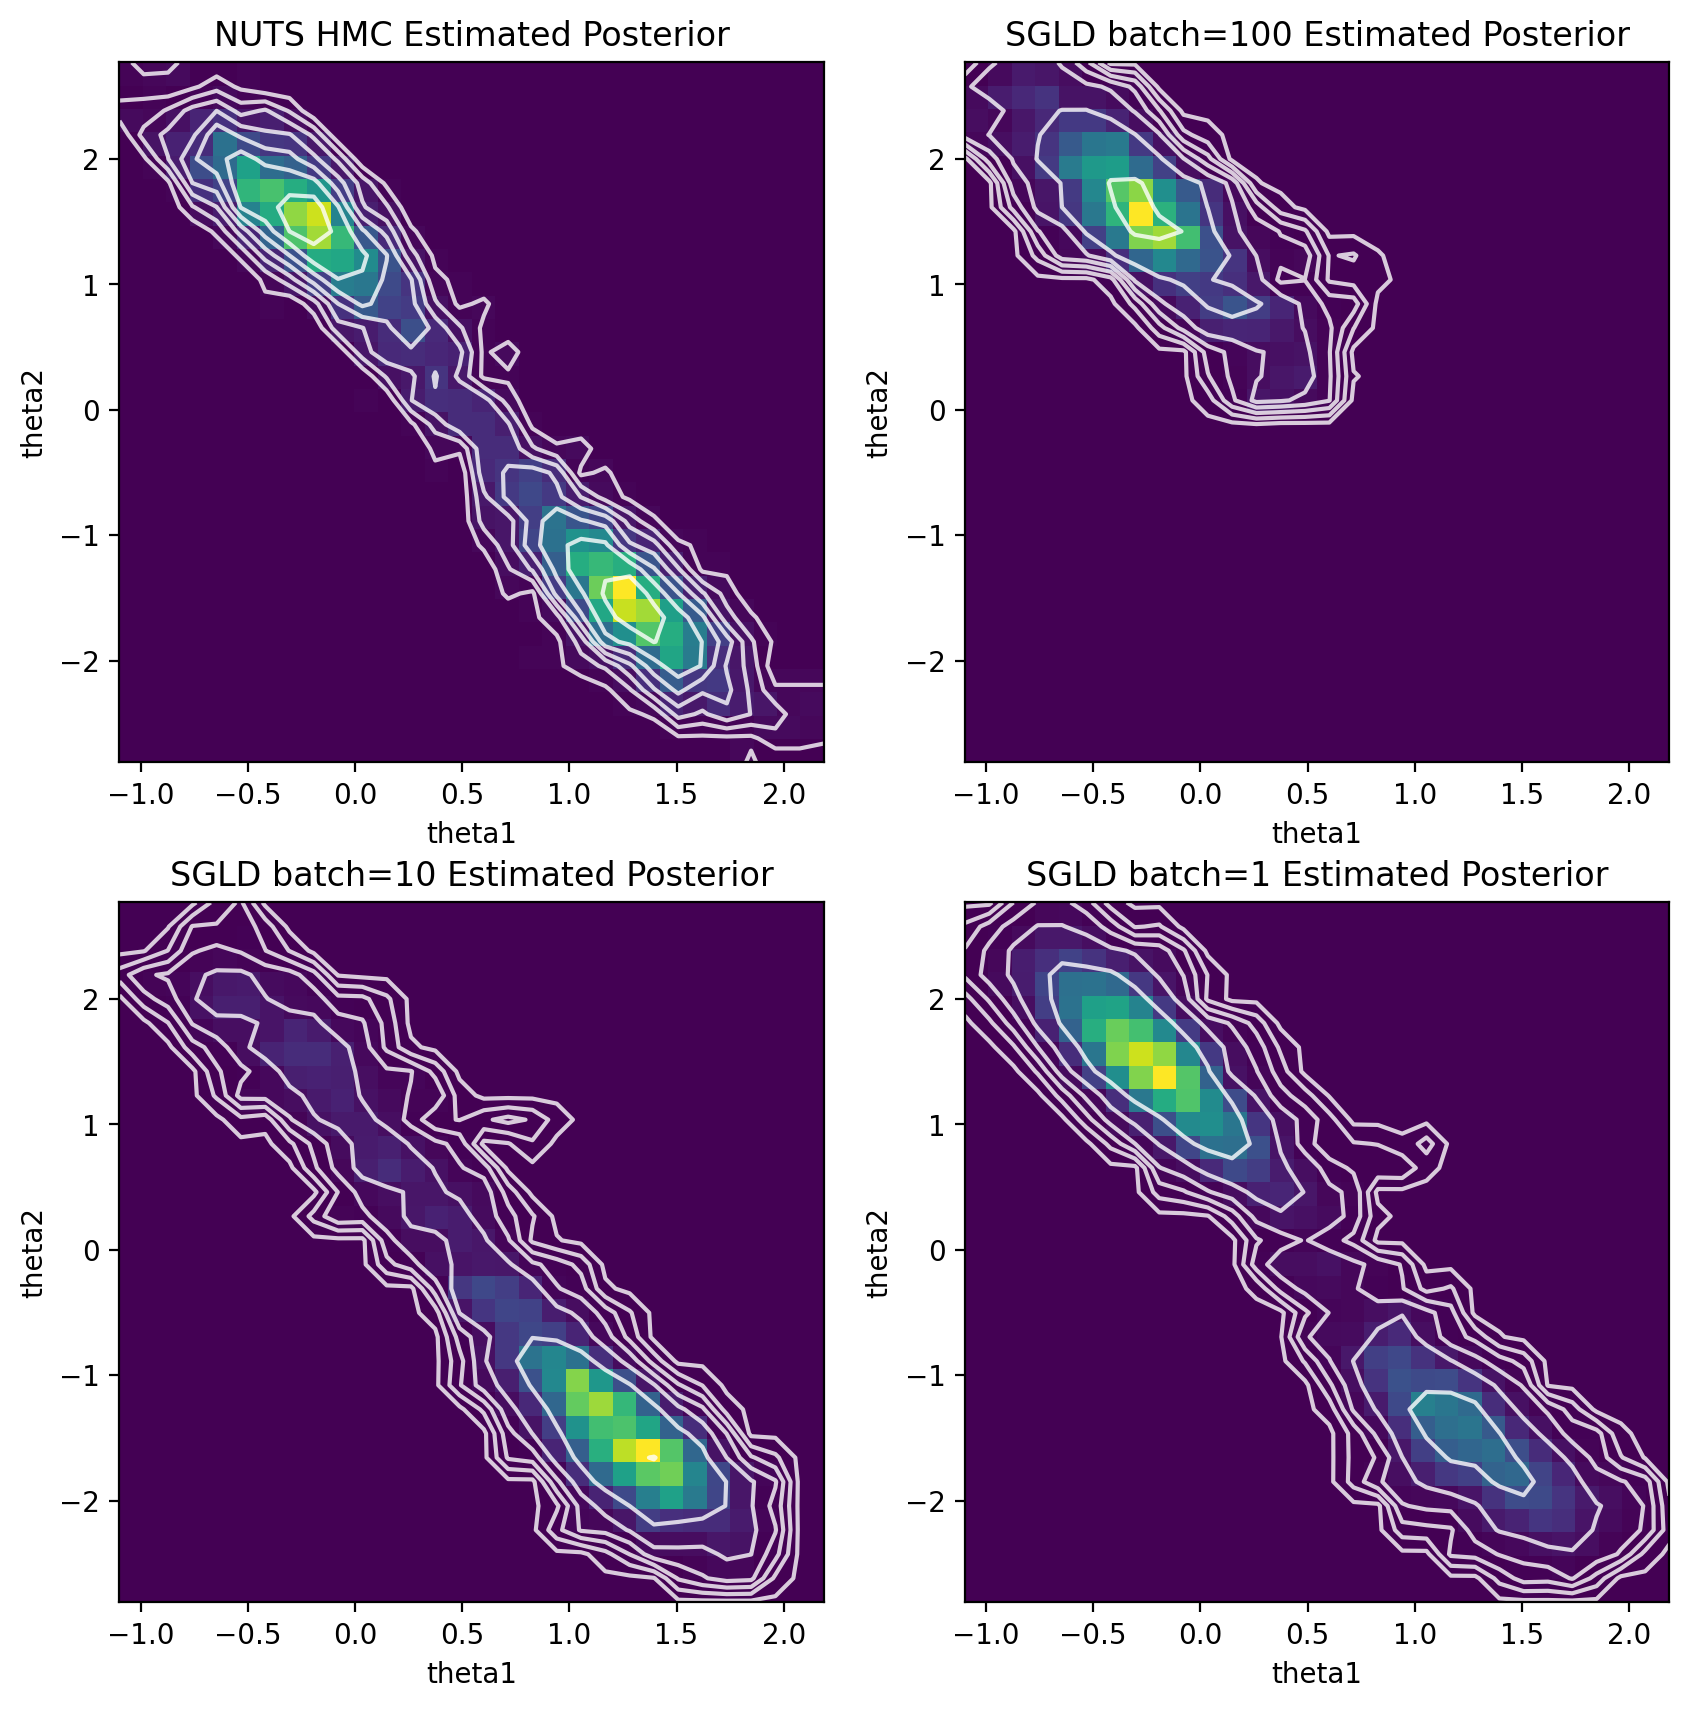

In [21]:
figure, axis = plt.subplots(2, 2, figsize=(10, 10), dpi=200)

X, Y = df_mcmc.transpose().values
X, Y
ax = axis[0, 0]
h, xs, ys, _ = ax.hist2d(X, Y, bins=[30, 30])
ax.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
            colors='white', alpha=0.8)
ax.set_title('NUTS HMC Estimated Posterior')
ax.set_xlabel('theta1')
ax.set_ylabel('theta2')
    
    
for i, batch_size in enumerate([100, 10, 1], start=1):
    df = df_sgld[batch_size]
    X, Y = df[['theta1', 'theta2']].transpose().values
    X, Y
    ax = axis[i // 2, i % 2]
    h, _, _, _ = ax.hist2d(X, Y, bins=[30, 30], range=[[xs.min(), xs.max()], [ys.min(), ys.max()]])
    ax.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
               colors='white', alpha=0.8)
    ax.set_title(f'SGLD batch={batch_size} Estimated Posterior')
    ax.set_xlabel('theta1')
    ax.set_ylabel('theta2')

In [22]:
#plt.figure(figsize=(8, 8), dpi=100)
#plt.xlim(*xlim)
#plt.ylim(*ylim)
#plt.contour(grid[:, :, 0], grid[:, :, 1], posterior, 
#            extent=xlim+ylim, 
#            levels=50)
#plt.title('Exact posterior density of mixture model')
#plt.xlabel('theta1')
#plt.ylabel('theta2')
#plt.plot(df_sgld['theta1'].mean(), df_sgld['theta2'].mean(), 'ro') 
#plt.tight_layout()

# Notes

## 2022-10-06

* Set number of epochs to always 10k * batch_size, so that each case would always have the same number of gradient updates (i.e. the total number of mini-batches run is constant).  
* Results vary:
   * The smaller mini-batches seem to travel best between the modes, probably because the gradients are more noisy and can travel father
   * I was able to get 2 modes with batch_size = 100 at one point, but this run didn't
   * Approximation is still off from NUTS sampler and the exact calculation


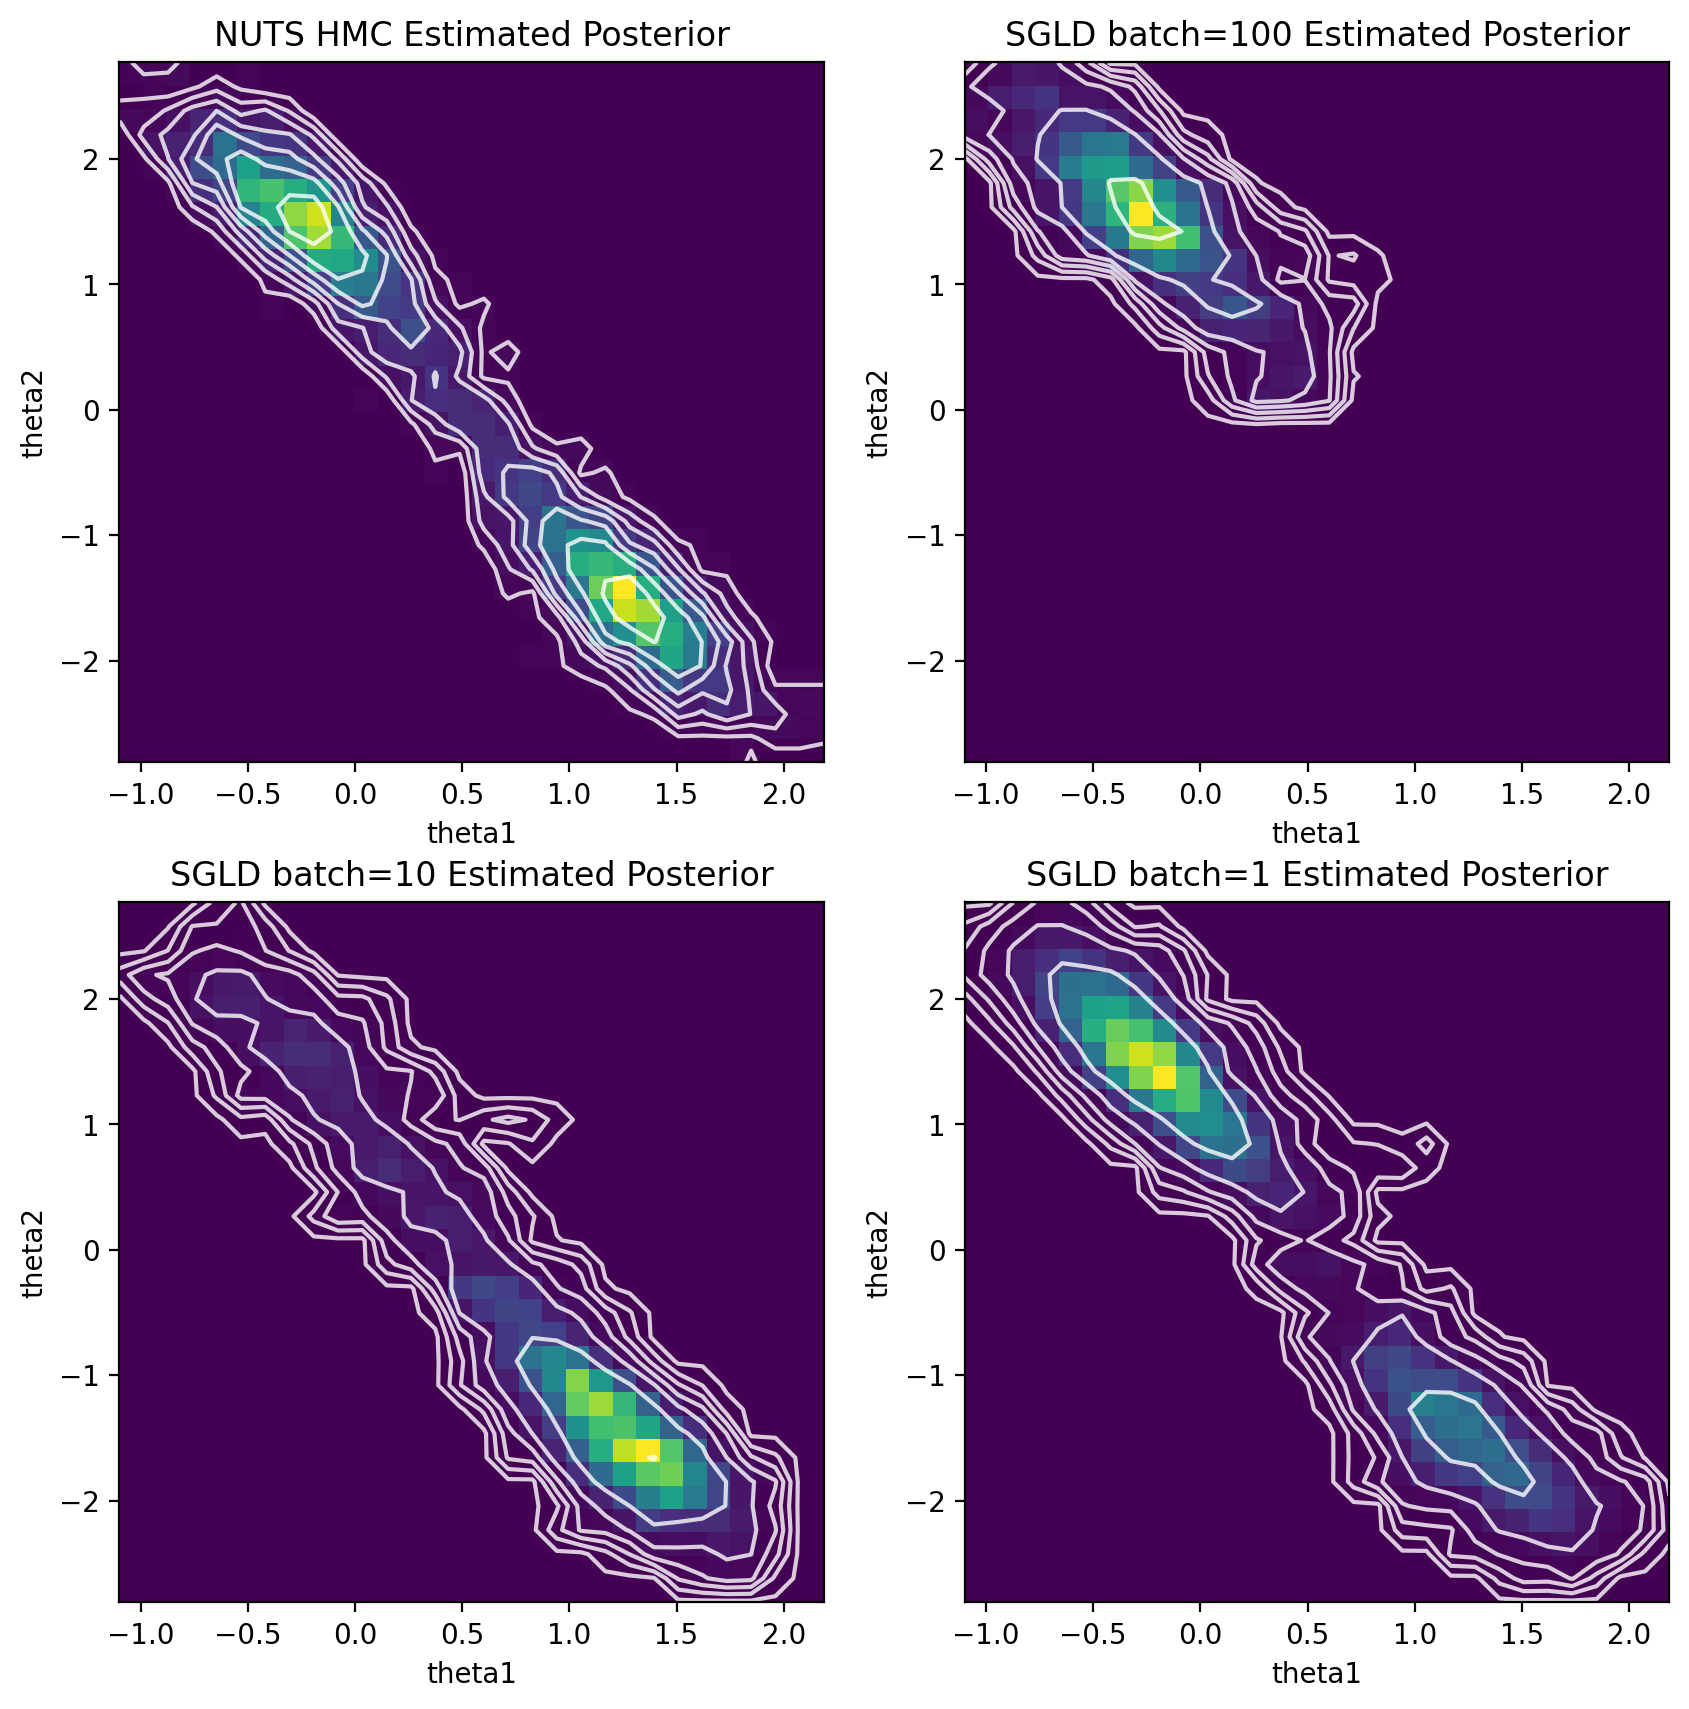

## 2022-10-05

* Looks like SGLD *sort of* works.  It found both modes but spent more time in the smaller mode.  I suppose that it would have trouble switching between modes when $\epsilon$ is small.
* I also had to decrease batch size to 1 (from 10) in order to clearly get 2 modes.  Perhaps when the batch size is too big, the gradient is too stable and not able to jump to the second mode (even with the added noise) -- needs more testing.

## 2022-10-04

* Fixed exact solution, just had a typo and needed to re-run
* Fixed another bug in SGD where my loss was not properly sizing likelihood vs. prior (N/batch_size vs. 1)
* Now all the MAP estimate is squarely in the centre of the countour plot maximum

TODO:

* Need to fix SGLD code to update each parameter separately (at least that's what I think the problem is) need to check.

## 2022-10-02

* Figured out what was wrong with SGD: I needed to use a the logpdf of a mixture distribution, NOT $N(0.5 *\theta_1 + 0.5 (\theta_1 + \theta_2), \sigma^2_x)$
* Took me a while to figure out how to use use `torch.distributions.Mixture` main bug was that I was using `torch.tensor([theta1, theta1 + theta2], requires_grad=True)` instead of `torch.cat([torch.unsqueeze(theta1, 0), torch.unsqueeze(theta1+theta2, 0)]`.  The difference is that former creates a new tensor and copies over data (so no lineage to parameters in the computation graph) vs. concat that keeps the lineage.  Additionally, I need to unsqueeze so that cat knows how to deal with tensors vs. scalars.
    * Lots of annoying stuff because I'm not that familiar with PyTorch
* Now problem is that I get something NUTS sample and SGD agree on the MAP estimate, but my "exact" solution doesn't.

TODO:
* Debug "exact" solution to make the contour plot line up with the other two

## 2022-10-01

* Modified data generation so that I actually get a multi-modal distribution by using x_std = 1.6 (vs. x_std=sqrt(2) like the paper says 
    * They must have had a pretty good random seed in order to get a multi-modal distribution, which I can often get with 1.5 but not sqrt(2)
* Made a mistake before relating posterior mean to MAP estimate, which are different.  HMC now more faithfully reproduces the multimodal distribution (approximately)
* But now SGD is quite off.  Theoretically, it should produce something close to the MAP estimate, but it produces something much smaller (with $\theta_2\approx 0$), I narrowed it down to the $\theta_2$ prior with the $\sigma_2^2=1$ makes it so that SGD seems to bind it very close to 0.  
    * Either by widening the variance or decreasing emphasis, I can get it closer to what I think the MAP estimate should be, but it's strange it does this.
    
TODO:
* Investigate why $\theta_2$ prior is pulling it so hard towards 0.
* IDEA: Try to implement the loss function myself instead of using `gaussian_nll_loss`

## 2022-09-30

* Had a bug in the "exact" calculation, now it's lining up with my SGLD much more closely
* HMC mean is strangely not that close to the center
    
TODO:
* Strangely enough, HMC is still kind of far off -- I should probably double check it
* Adjust samples by $\epsilon$ as described in the paper

## 2022-09-29

* Due to the high correlation at the tailend, so we don't get a perfect sample of the distribution like in HMC from the paper 
    * `the simple sample average will over-emphasize the tail end of the sequence where there is higher correlation among the samples, resulting in a higher variance estimator.`
    * `Measuring the sampling threshold will only beimportant if one needs to faithfully represent the posterior distribution with a finite collection of samples`
    
    
TODO:

* Adjust samples by $\epsilon$ as described in the paper
* Play around with lower noise threhold